In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3857408, 828)
(3857408, 8)
validation
(519808, 828)
(519808, 8)
test
(526016, 828)
(526016, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/386 [..............................] - ETA: 8:36 - loss: 2.2999 - STD: 0.0763 - MAE: 0.2189

  5/386 [..............................] - ETA: 5s - loss: 2.1447 - STD: 0.0363 - MAE: 0.2187  

  8/386 [..............................] - ETA: 6s - loss: 2.1332 - STD: 0.0356 - MAE: 0.2187

 12/386 [..............................] - ETA: 5s - loss: 2.1160 - STD: 0.0276 - MAE: 0.2187

 16/386 [>.............................] - ETA: 5s - loss: 2.1079 - STD: 0.0255 - MAE: 0.2186

 20/386 [>.............................] - ETA: 5s - loss: 2.1008 - STD: 0.0233 - MAE: 0.2186

 24/386 [>.............................] - ETA: 5s - loss: 2.0925 - STD: 0.0210 - MAE: 0.2184

 28/386 [=>............................] - ETA: 5s - loss: 2.0826 - STD: 0.0207 - MAE: 0.2182

 32/386 [=>............................] - ETA: 5s - loss: 2.0685 - STD: 0.0220 - MAE: 0.2177

 36/386 [=>............................] - ETA: 5s - loss: 2.0513 - STD: 0.0251 - MAE: 0.2169

 40/386 [==>...........................] - ETA: 5s - loss: 2.0338 - STD: 0.0292 - MAE: 0.2161

 44/386 [==>...........................] - ETA: 5s - loss: 2.0168 - STD: 0.0334 - MAE: 0.2152

 48/386 [==>...........................] - ETA: 5s - loss: 2.0009 - STD: 0.0372 - MAE: 0.2143

 52/386 [===>..........................] - ETA: 5s - loss: 1.9854 - STD: 0.0405 - MAE: 0.2135

 56/386 [===>..........................] - ETA: 5s - loss: 1.9702 - STD: 0.0435 - MAE: 0.2128

 60/386 [===>..........................] - ETA: 5s - loss: 1.9546 - STD: 0.0464 - MAE: 0.2120

 64/386 [===>..........................] - ETA: 4s - loss: 1.9384 - STD: 0.0492 - MAE: 0.2111

 68/386 [====>.........................] - ETA: 4s - loss: 1.9217 - STD: 0.0520 - MAE: 0.2103

 72/386 [====>.........................] - ETA: 4s - loss: 1.9047 - STD: 0.0548 - MAE: 0.2094

 75/386 [====>.........................] - ETA: 4s - loss: 1.8918 - STD: 0.0568 - MAE: 0.2087

 79/386 [=====>........................] - ETA: 4s - loss: 1.8748 - STD: 0.0596 - MAE: 0.2077

 83/386 [=====>........................] - ETA: 4s - loss: 1.8580 - STD: 0.0624 - MAE: 0.2068

 86/386 [=====>........................] - ETA: 4s - loss: 1.8458 - STD: 0.0644 - MAE: 0.2060

 90/386 [=====>........................] - ETA: 4s - loss: 1.8298 - STD: 0.0671 - MAE: 0.2050

 94/386 [======>.......................] - ETA: 4s - loss: 1.8145 - STD: 0.0697 - MAE: 0.2041

 98/386 [======>.......................] - ETA: 4s - loss: 1.7992 - STD: 0.0722 - MAE: 0.2031

102/386 [======>.......................] - ETA: 4s - loss: 1.7845 - STD: 0.0746 - MAE: 0.2021

106/386 [=======>......................] - ETA: 4s - loss: 1.7700 - STD: 0.0771 - MAE: 0.2011

110/386 [=======>......................] - ETA: 4s - loss: 1.7558 - STD: 0.0795 - MAE: 0.2001

114/386 [=======>......................] - ETA: 4s - loss: 1.7421 - STD: 0.0818 - MAE: 0.1991

118/386 [========>.....................] - ETA: 4s - loss: 1.7289 - STD: 0.0841 - MAE: 0.1982

122/386 [========>.....................] - ETA: 4s - loss: 1.7161 - STD: 0.0864 - MAE: 0.1972

126/386 [========>.....................] - ETA: 4s - loss: 1.7039 - STD: 0.0886 - MAE: 0.1963

130/386 [=========>....................] - ETA: 3s - loss: 1.6924 - STD: 0.0906 - MAE: 0.1954

133/386 [=========>....................] - ETA: 3s - loss: 1.6841 - STD: 0.0922 - MAE: 0.1947

137/386 [=========>....................] - ETA: 3s - loss: 1.6734 - STD: 0.0940 - MAE: 0.1939

141/386 [=========>....................] - ETA: 3s - loss: 1.6630 - STD: 0.0959 - MAE: 0.1931

145/386 [==========>...................] - ETA: 3s - loss: 1.6529 - STD: 0.0976 - MAE: 0.1923

149/386 [==========>...................] - ETA: 3s - loss: 1.6433 - STD: 0.0993 - MAE: 0.1916

153/386 [==========>...................] - ETA: 3s - loss: 1.6341 - STD: 0.1010 - MAE: 0.1909

157/386 [===========>..................] - ETA: 3s - loss: 1.6250 - STD: 0.1025 - MAE: 0.1901

160/386 [===========>..................] - ETA: 3s - loss: 1.6186 - STD: 0.1037 - MAE: 0.1896

163/386 [===========>..................] - ETA: 3s - loss: 1.6124 - STD: 0.1048 - MAE: 0.1891

167/386 [===========>..................] - ETA: 3s - loss: 1.6042 - STD: 0.1062 - MAE: 0.1885

171/386 [============>.................] - ETA: 3s - loss: 1.5964 - STD: 0.1076 - MAE: 0.1878

175/386 [============>.................] - ETA: 3s - loss: 1.5887 - STD: 0.1089 - MAE: 0.1872

179/386 [============>.................] - ETA: 3s - loss: 1.5813 - STD: 0.1102 - MAE: 0.1866

183/386 [=============>................] - ETA: 3s - loss: 1.5740 - STD: 0.1115 - MAE: 0.1860

187/386 [=============>................] - ETA: 3s - loss: 1.5669 - STD: 0.1127 - MAE: 0.1854

191/386 [=============>................] - ETA: 3s - loss: 1.5601 - STD: 0.1139 - MAE: 0.1849

195/386 [==============>...............] - ETA: 2s - loss: 1.5534 - STD: 0.1150 - MAE: 0.1843

199/386 [==============>...............] - ETA: 2s - loss: 1.5471 - STD: 0.1161 - MAE: 0.1838

203/386 [==============>...............] - ETA: 2s - loss: 1.5408 - STD: 0.1172 - MAE: 0.1833

207/386 [===============>..............] - ETA: 2s - loss: 1.5348 - STD: 0.1183 - MAE: 0.1828

211/386 [===============>..............] - ETA: 2s - loss: 1.5288 - STD: 0.1193 - MAE: 0.1823

215/386 [===============>..............] - ETA: 2s - loss: 1.5230 - STD: 0.1203 - MAE: 0.1818

219/386 [================>.............] - ETA: 2s - loss: 1.5174 - STD: 0.1213 - MAE: 0.1813

223/386 [================>.............] - ETA: 2s - loss: 1.5119 - STD: 0.1223 - MAE: 0.1808

227/386 [================>.............] - ETA: 2s - loss: 1.5066 - STD: 0.1232 - MAE: 0.1804

231/386 [================>.............] - ETA: 2s - loss: 1.5015 - STD: 0.1241 - MAE: 0.1799

235/386 [=================>............] - ETA: 2s - loss: 1.4965 - STD: 0.1250 - MAE: 0.1795

239/386 [=================>............] - ETA: 2s - loss: 1.4916 - STD: 0.1258 - MAE: 0.1791

243/386 [=================>............] - ETA: 2s - loss: 1.4868 - STD: 0.1267 - MAE: 0.1787

247/386 [==================>...........] - ETA: 2s - loss: 1.4822 - STD: 0.1275 - MAE: 0.1783

251/386 [==================>...........] - ETA: 2s - loss: 1.4777 - STD: 0.1283 - MAE: 0.1779

255/386 [==================>...........] - ETA: 2s - loss: 1.4733 - STD: 0.1291 - MAE: 0.1775

259/386 [===================>..........] - ETA: 1s - loss: 1.4691 - STD: 0.1298 - MAE: 0.1771

263/386 [===================>..........] - ETA: 1s - loss: 1.4648 - STD: 0.1306 - MAE: 0.1767

266/386 [===================>..........] - ETA: 1s - loss: 1.4616 - STD: 0.1312 - MAE: 0.1764

270/386 [===================>..........] - ETA: 1s - loss: 1.4575 - STD: 0.1319 - MAE: 0.1761

274/386 [====================>.........] - ETA: 1s - loss: 1.4536 - STD: 0.1326 - MAE: 0.1757

278/386 [====================>.........] - ETA: 1s - loss: 1.4496 - STD: 0.1333 - MAE: 0.1754

282/386 [====================>.........] - ETA: 1s - loss: 1.4458 - STD: 0.1339 - MAE: 0.1750

286/386 [=====================>........] - ETA: 1s - loss: 1.4421 - STD: 0.1346 - MAE: 0.1747

290/386 [=====================>........] - ETA: 1s - loss: 1.4384 - STD: 0.1353 - MAE: 0.1744

294/386 [=====================>........] - ETA: 1s - loss: 1.4347 - STD: 0.1359 - MAE: 0.1740

298/386 [======================>.......] - ETA: 1s - loss: 1.4312 - STD: 0.1365 - MAE: 0.1737

302/386 [======================>.......] - ETA: 1s - loss: 1.4277 - STD: 0.1371 - MAE: 0.1734

306/386 [======================>.......] - ETA: 1s - loss: 1.4241 - STD: 0.1377 - MAE: 0.1731

310/386 [=======================>......] - ETA: 1s - loss: 1.4206 - STD: 0.1383 - MAE: 0.1728

314/386 [=======================>......] - ETA: 1s - loss: 1.4172 - STD: 0.1389 - MAE: 0.1725

318/386 [=======================>......] - ETA: 1s - loss: 1.4138 - STD: 0.1395 - MAE: 0.1722

322/386 [========================>.....] - ETA: 0s - loss: 1.4105 - STD: 0.1400 - MAE: 0.1719

326/386 [========================>.....] - ETA: 0s - loss: 1.4073 - STD: 0.1406 - MAE: 0.1716

330/386 [========================>.....] - ETA: 0s - loss: 1.4044 - STD: 0.1411 - MAE: 0.1713

334/386 [========================>.....] - ETA: 0s - loss: 1.4013 - STD: 0.1417 - MAE: 0.1710

338/386 [=========================>....] - ETA: 0s - loss: 1.3982 - STD: 0.1422 - MAE: 0.1708

342/386 [=========================>....] - ETA: 0s - loss: 1.3951 - STD: 0.1427 - MAE: 0.1705

346/386 [=========================>....] - ETA: 0s - loss: 1.3921 - STD: 0.1432 - MAE: 0.1702

350/386 [==========================>...] - ETA: 0s - loss: 1.3891 - STD: 0.1437 - MAE: 0.1699

354/386 [==========================>...] - ETA: 0s - loss: 1.3864 - STD: 0.1442 - MAE: 0.1697

357/386 [==========================>...] - ETA: 0s - loss: 1.3842 - STD: 0.1446 - MAE: 0.1695

361/386 [===========================>..] - ETA: 0s - loss: 1.3813 - STD: 0.1451 - MAE: 0.1692

365/386 [===========================>..] - ETA: 0s - loss: 1.3785 - STD: 0.1455 - MAE: 0.1689

369/386 [===========================>..] - ETA: 0s - loss: 1.3758 - STD: 0.1460 - MAE: 0.1687

373/386 [===========================>..] - ETA: 0s - loss: 1.3730 - STD: 0.1465 - MAE: 0.1684

377/386 [============================>.] - ETA: 0s - loss: 1.3702 - STD: 0.1470 - MAE: 0.1682

381/386 [============================>.] - ETA: 0s - loss: 1.3675 - STD: 0.1474 - MAE: 0.1679

385/386 [============================>.] - ETA: 0s - loss: 1.3650 - STD: 0.1479 - MAE: 0.1677

386/386 [==============================] - 9s 21ms/step - loss: 1.3644 - STD: 0.1480 - MAE: 0.1676 - val_loss: 1.2061 - val_STD: 0.1844 - val_MAE: 0.1506


Epoch 2/10000


  1/386 [..............................] - ETA: 19s - loss: 1.1388 - STD: 0.1884 - MAE: 0.1466

  5/386 [..............................] - ETA: 6s - loss: 1.1153 - STD: 0.1896 - MAE: 0.1448 

  9/386 [..............................] - ETA: 6s - loss: 1.1121 - STD: 0.1903 - MAE: 0.1442

 13/386 [>.............................] - ETA: 5s - loss: 1.1176 - STD: 0.1904 - MAE: 0.1445

 17/386 [>.............................] - ETA: 5s - loss: 1.1150 - STD: 0.1908 - MAE: 0.1442

 21/386 [>.............................] - ETA: 5s - loss: 1.1117 - STD: 0.1910 - MAE: 0.1439

 25/386 [>.............................] - ETA: 5s - loss: 1.1118 - STD: 0.1911 - MAE: 0.1438

 29/386 [=>............................] - ETA: 5s - loss: 1.1113 - STD: 0.1913 - MAE: 0.1437

 33/386 [=>............................] - ETA: 5s - loss: 1.1106 - STD: 0.1915 - MAE: 0.1436

 37/386 [=>............................] - ETA: 5s - loss: 1.1088 - STD: 0.1915 - MAE: 0.1436

 41/386 [==>...........................] - ETA: 5s - loss: 1.1067 - STD: 0.1916 - MAE: 0.1434

 45/386 [==>...........................] - ETA: 5s - loss: 1.1047 - STD: 0.1918 - MAE: 0.1432

 48/386 [==>...........................] - ETA: 5s - loss: 1.1037 - STD: 0.1920 - MAE: 0.1431

 52/386 [===>..........................] - ETA: 5s - loss: 1.1021 - STD: 0.1921 - MAE: 0.1429

 55/386 [===>..........................] - ETA: 5s - loss: 1.1012 - STD: 0.1923 - MAE: 0.1428

 58/386 [===>..........................] - ETA: 5s - loss: 1.1009 - STD: 0.1925 - MAE: 0.1428

 62/386 [===>..........................] - ETA: 5s - loss: 1.1021 - STD: 0.1926 - MAE: 0.1428

 65/386 [====>.........................] - ETA: 5s - loss: 1.1037 - STD: 0.1927 - MAE: 0.1428

 69/386 [====>.........................] - ETA: 4s - loss: 1.1036 - STD: 0.1928 - MAE: 0.1428

 73/386 [====>.........................] - ETA: 4s - loss: 1.1029 - STD: 0.1928 - MAE: 0.1427

 76/386 [====>.........................] - ETA: 4s - loss: 1.1024 - STD: 0.1928 - MAE: 0.1427

 80/386 [=====>........................] - ETA: 4s - loss: 1.1010 - STD: 0.1929 - MAE: 0.1426

 84/386 [=====>........................] - ETA: 4s - loss: 1.1001 - STD: 0.1931 - MAE: 0.1425

 88/386 [=====>........................] - ETA: 4s - loss: 1.0989 - STD: 0.1932 - MAE: 0.1424

 92/386 [======>.......................] - ETA: 4s - loss: 1.0979 - STD: 0.1934 - MAE: 0.1423

 95/386 [======>.......................] - ETA: 4s - loss: 1.0975 - STD: 0.1935 - MAE: 0.1422

 99/386 [======>.......................] - ETA: 4s - loss: 1.0971 - STD: 0.1936 - MAE: 0.1421

103/386 [=======>......................] - ETA: 4s - loss: 1.0964 - STD: 0.1936 - MAE: 0.1421

107/386 [=======>......................] - ETA: 4s - loss: 1.0960 - STD: 0.1937 - MAE: 0.1420

111/386 [=======>......................] - ETA: 4s - loss: 1.0950 - STD: 0.1939 - MAE: 0.1419

115/386 [=======>......................] - ETA: 4s - loss: 1.0938 - STD: 0.1940 - MAE: 0.1418

119/386 [========>.....................] - ETA: 4s - loss: 1.0930 - STD: 0.1941 - MAE: 0.1417

123/386 [========>.....................] - ETA: 4s - loss: 1.0926 - STD: 0.1942 - MAE: 0.1416

127/386 [========>.....................] - ETA: 4s - loss: 1.0920 - STD: 0.1943 - MAE: 0.1416

131/386 [=========>....................] - ETA: 3s - loss: 1.0917 - STD: 0.1945 - MAE: 0.1415

135/386 [=========>....................] - ETA: 3s - loss: 1.0916 - STD: 0.1946 - MAE: 0.1415

139/386 [=========>....................] - ETA: 3s - loss: 1.0911 - STD: 0.1946 - MAE: 0.1414

143/386 [==========>...................] - ETA: 3s - loss: 1.0907 - STD: 0.1947 - MAE: 0.1413

147/386 [==========>...................] - ETA: 3s - loss: 1.0900 - STD: 0.1948 - MAE: 0.1413

151/386 [==========>...................] - ETA: 3s - loss: 1.0892 - STD: 0.1949 - MAE: 0.1412

155/386 [===========>..................] - ETA: 3s - loss: 1.0884 - STD: 0.1950 - MAE: 0.1411

159/386 [===========>..................] - ETA: 3s - loss: 1.0880 - STD: 0.1951 - MAE: 0.1410

163/386 [===========>..................] - ETA: 3s - loss: 1.0878 - STD: 0.1952 - MAE: 0.1410

167/386 [===========>..................] - ETA: 3s - loss: 1.0873 - STD: 0.1952 - MAE: 0.1409

171/386 [============>.................] - ETA: 3s - loss: 1.0867 - STD: 0.1953 - MAE: 0.1409

175/386 [============>.................] - ETA: 3s - loss: 1.0860 - STD: 0.1954 - MAE: 0.1408

178/386 [============>.................] - ETA: 3s - loss: 1.0854 - STD: 0.1955 - MAE: 0.1408

181/386 [=============>................] - ETA: 3s - loss: 1.0849 - STD: 0.1955 - MAE: 0.1407

185/386 [=============>................] - ETA: 3s - loss: 1.0840 - STD: 0.1956 - MAE: 0.1406

189/386 [=============>................] - ETA: 3s - loss: 1.0831 - STD: 0.1957 - MAE: 0.1405

193/386 [==============>...............] - ETA: 3s - loss: 1.0823 - STD: 0.1958 - MAE: 0.1405

197/386 [==============>...............] - ETA: 2s - loss: 1.0817 - STD: 0.1959 - MAE: 0.1404

201/386 [==============>...............] - ETA: 2s - loss: 1.0812 - STD: 0.1960 - MAE: 0.1403

205/386 [==============>...............] - ETA: 2s - loss: 1.0806 - STD: 0.1961 - MAE: 0.1403

209/386 [===============>..............] - ETA: 2s - loss: 1.0798 - STD: 0.1962 - MAE: 0.1402

213/386 [===============>..............] - ETA: 2s - loss: 1.0790 - STD: 0.1962 - MAE: 0.1401

217/386 [===============>..............] - ETA: 2s - loss: 1.0784 - STD: 0.1963 - MAE: 0.1400

221/386 [================>.............] - ETA: 2s - loss: 1.0778 - STD: 0.1964 - MAE: 0.1400

224/386 [================>.............] - ETA: 2s - loss: 1.0775 - STD: 0.1965 - MAE: 0.1399

228/386 [================>.............] - ETA: 2s - loss: 1.0767 - STD: 0.1966 - MAE: 0.1398

231/386 [================>.............] - ETA: 2s - loss: 1.0762 - STD: 0.1966 - MAE: 0.1398

235/386 [=================>............] - ETA: 2s - loss: 1.0755 - STD: 0.1967 - MAE: 0.1397

239/386 [=================>............] - ETA: 2s - loss: 1.0749 - STD: 0.1968 - MAE: 0.1397

242/386 [=================>............] - ETA: 2s - loss: 1.0744 - STD: 0.1969 - MAE: 0.1396

246/386 [==================>...........] - ETA: 2s - loss: 1.0739 - STD: 0.1970 - MAE: 0.1395

250/386 [==================>...........] - ETA: 2s - loss: 1.0737 - STD: 0.1971 - MAE: 0.1395

254/386 [==================>...........] - ETA: 2s - loss: 1.0736 - STD: 0.1971 - MAE: 0.1395

258/386 [===================>..........] - ETA: 1s - loss: 1.0732 - STD: 0.1972 - MAE: 0.1394

261/386 [===================>..........] - ETA: 1s - loss: 1.0728 - STD: 0.1972 - MAE: 0.1394

265/386 [===================>..........] - ETA: 1s - loss: 1.0723 - STD: 0.1973 - MAE: 0.1393

269/386 [===================>..........] - ETA: 1s - loss: 1.0716 - STD: 0.1974 - MAE: 0.1393

273/386 [====================>.........] - ETA: 1s - loss: 1.0711 - STD: 0.1975 - MAE: 0.1392

277/386 [====================>.........] - ETA: 1s - loss: 1.0707 - STD: 0.1975 - MAE: 0.1391

281/386 [====================>.........] - ETA: 1s - loss: 1.0703 - STD: 0.1976 - MAE: 0.1391

285/386 [=====================>........] - ETA: 1s - loss: 1.0698 - STD: 0.1977 - MAE: 0.1390

289/386 [=====================>........] - ETA: 1s - loss: 1.0691 - STD: 0.1978 - MAE: 0.1390

293/386 [=====================>........] - ETA: 1s - loss: 1.0685 - STD: 0.1978 - MAE: 0.1389

297/386 [======================>.......] - ETA: 1s - loss: 1.0680 - STD: 0.1979 - MAE: 0.1388

301/386 [======================>.......] - ETA: 1s - loss: 1.0673 - STD: 0.1980 - MAE: 0.1388

305/386 [======================>.......] - ETA: 1s - loss: 1.0666 - STD: 0.1981 - MAE: 0.1387

308/386 [======================>.......] - ETA: 1s - loss: 1.0661 - STD: 0.1981 - MAE: 0.1387

312/386 [=======================>......] - ETA: 1s - loss: 1.0655 - STD: 0.1982 - MAE: 0.1386

316/386 [=======================>......] - ETA: 1s - loss: 1.0647 - STD: 0.1983 - MAE: 0.1385

320/386 [=======================>......] - ETA: 1s - loss: 1.0640 - STD: 0.1983 - MAE: 0.1384

324/386 [========================>.....] - ETA: 0s - loss: 1.0636 - STD: 0.1984 - MAE: 0.1384

328/386 [========================>.....] - ETA: 0s - loss: 1.0640 - STD: 0.1985 - MAE: 0.1384

332/386 [========================>.....] - ETA: 0s - loss: 1.0637 - STD: 0.1986 - MAE: 0.1383

336/386 [=========================>....] - ETA: 0s - loss: 1.0632 - STD: 0.1987 - MAE: 0.1383

340/386 [=========================>....] - ETA: 0s - loss: 1.0627 - STD: 0.1987 - MAE: 0.1382

344/386 [=========================>....] - ETA: 0s - loss: 1.0621 - STD: 0.1988 - MAE: 0.1382

348/386 [==========================>...] - ETA: 0s - loss: 1.0615 - STD: 0.1989 - MAE: 0.1381

352/386 [==========================>...] - ETA: 0s - loss: 1.0610 - STD: 0.1989 - MAE: 0.1381

355/386 [==========================>...] - ETA: 0s - loss: 1.0606 - STD: 0.1990 - MAE: 0.1380

359/386 [==========================>...] - ETA: 0s - loss: 1.0602 - STD: 0.1990 - MAE: 0.1380

363/386 [===========================>..] - ETA: 0s - loss: 1.0595 - STD: 0.1991 - MAE: 0.1379

367/386 [===========================>..] - ETA: 0s - loss: 1.0590 - STD: 0.1992 - MAE: 0.1379

371/386 [===========================>..] - ETA: 0s - loss: 1.0584 - STD: 0.1992 - MAE: 0.1378

375/386 [============================>.] - ETA: 0s - loss: 1.0578 - STD: 0.1993 - MAE: 0.1377

379/386 [============================>.] - ETA: 0s - loss: 1.0574 - STD: 0.1994 - MAE: 0.1377

382/386 [============================>.] - ETA: 0s - loss: 1.0570 - STD: 0.1994 - MAE: 0.1376

386/386 [==============================] - ETA: 0s - loss: 1.0567 - STD: 0.1995 - MAE: 0.1376

386/386 [==============================] - 7s 18ms/step - loss: 1.0567 - STD: 0.1995 - MAE: 0.1376 - val_loss: 1.1266 - val_STD: 0.1995 - val_MAE: 0.1412


Epoch 3/10000


  1/386 [..............................] - ETA: 18s - loss: 1.0138 - STD: 0.2055 - MAE: 0.1329

  5/386 [..............................] - ETA: 5s - loss: 1.0202 - STD: 0.2062 - MAE: 0.1329 

  9/386 [..............................] - ETA: 6s - loss: 1.0335 - STD: 0.2063 - MAE: 0.1336

 13/386 [>.............................] - ETA: 5s - loss: 1.0417 - STD: 0.2065 - MAE: 0.1340

 16/386 [>.............................] - ETA: 6s - loss: 1.0459 - STD: 0.2065 - MAE: 0.1342

 20/386 [>.............................] - ETA: 5s - loss: 1.0538 - STD: 0.2061 - MAE: 0.1348

 24/386 [>.............................] - ETA: 5s - loss: 1.0567 - STD: 0.2059 - MAE: 0.1350

 28/386 [=>............................] - ETA: 5s - loss: 1.0531 - STD: 0.2059 - MAE: 0.1348

 32/386 [=>............................] - ETA: 5s - loss: 1.0506 - STD: 0.2054 - MAE: 0.1349

 36/386 [=>............................] - ETA: 5s - loss: 1.0470 - STD: 0.2051 - MAE: 0.1348

 40/386 [==>...........................] - ETA: 5s - loss: 1.0433 - STD: 0.2050 - MAE: 0.1347

 44/386 [==>...........................] - ETA: 5s - loss: 1.0400 - STD: 0.2050 - MAE: 0.1345

 48/386 [==>...........................] - ETA: 5s - loss: 1.0365 - STD: 0.2050 - MAE: 0.1343

 51/386 [==>...........................] - ETA: 5s - loss: 1.0338 - STD: 0.2050 - MAE: 0.1341

 55/386 [===>..........................] - ETA: 5s - loss: 1.0311 - STD: 0.2051 - MAE: 0.1340

 59/386 [===>..........................] - ETA: 5s - loss: 1.0285 - STD: 0.2052 - MAE: 0.1338

 63/386 [===>..........................] - ETA: 5s - loss: 1.0259 - STD: 0.2052 - MAE: 0.1336

 67/386 [====>.........................] - ETA: 5s - loss: 1.0237 - STD: 0.2054 - MAE: 0.1334

 71/386 [====>.........................] - ETA: 4s - loss: 1.0216 - STD: 0.2054 - MAE: 0.1333

 75/386 [====>.........................] - ETA: 4s - loss: 1.0201 - STD: 0.2055 - MAE: 0.1331

 79/386 [=====>........................] - ETA: 4s - loss: 1.0190 - STD: 0.2056 - MAE: 0.1330

 83/386 [=====>........................] - ETA: 4s - loss: 1.0179 - STD: 0.2057 - MAE: 0.1329

 87/386 [=====>........................] - ETA: 4s - loss: 1.0164 - STD: 0.2059 - MAE: 0.1328

 91/386 [======>.......................] - ETA: 4s - loss: 1.0151 - STD: 0.2059 - MAE: 0.1327

 95/386 [======>.......................] - ETA: 4s - loss: 1.0133 - STD: 0.2060 - MAE: 0.1326

 99/386 [======>.......................] - ETA: 4s - loss: 1.0124 - STD: 0.2061 - MAE: 0.1325

103/386 [=======>......................] - ETA: 4s - loss: 1.0113 - STD: 0.2062 - MAE: 0.1324

107/386 [=======>......................] - ETA: 4s - loss: 1.0104 - STD: 0.2063 - MAE: 0.1323

111/386 [=======>......................] - ETA: 4s - loss: 1.0097 - STD: 0.2064 - MAE: 0.1322

114/386 [=======>......................] - ETA: 4s - loss: 1.0095 - STD: 0.2065 - MAE: 0.1322

118/386 [========>.....................] - ETA: 4s - loss: 1.0085 - STD: 0.2066 - MAE: 0.1321

122/386 [========>.....................] - ETA: 4s - loss: 1.0079 - STD: 0.2067 - MAE: 0.1320

126/386 [========>.....................] - ETA: 4s - loss: 1.0069 - STD: 0.2067 - MAE: 0.1319

130/386 [=========>....................] - ETA: 3s - loss: 1.0060 - STD: 0.2068 - MAE: 0.1318

134/386 [=========>....................] - ETA: 3s - loss: 1.0054 - STD: 0.2069 - MAE: 0.1318

138/386 [=========>....................] - ETA: 3s - loss: 1.0052 - STD: 0.2070 - MAE: 0.1317

141/386 [=========>....................] - ETA: 3s - loss: 1.0049 - STD: 0.2070 - MAE: 0.1317

145/386 [==========>...................] - ETA: 3s - loss: 1.0040 - STD: 0.2070 - MAE: 0.1316

149/386 [==========>...................] - ETA: 3s - loss: 1.0031 - STD: 0.2071 - MAE: 0.1315

153/386 [==========>...................] - ETA: 3s - loss: 1.0023 - STD: 0.2072 - MAE: 0.1315

157/386 [===========>..................] - ETA: 3s - loss: 1.0015 - STD: 0.2073 - MAE: 0.1314

161/386 [===========>..................] - ETA: 3s - loss: 1.0009 - STD: 0.2074 - MAE: 0.1313

165/386 [===========>..................] - ETA: 3s - loss: 1.0009 - STD: 0.2075 - MAE: 0.1313

169/386 [============>.................] - ETA: 3s - loss: 1.0001 - STD: 0.2075 - MAE: 0.1312

173/386 [============>.................] - ETA: 3s - loss: 0.9996 - STD: 0.2076 - MAE: 0.1312

177/386 [============>.................] - ETA: 3s - loss: 0.9991 - STD: 0.2076 - MAE: 0.1311

181/386 [=============>................] - ETA: 3s - loss: 0.9988 - STD: 0.2077 - MAE: 0.1311

185/386 [=============>................] - ETA: 3s - loss: 0.9991 - STD: 0.2077 - MAE: 0.1311

189/386 [=============>................] - ETA: 3s - loss: 0.9989 - STD: 0.2078 - MAE: 0.1310

193/386 [==============>...............] - ETA: 2s - loss: 0.9987 - STD: 0.2079 - MAE: 0.1310

197/386 [==============>...............] - ETA: 2s - loss: 0.9981 - STD: 0.2079 - MAE: 0.1309

201/386 [==============>...............] - ETA: 2s - loss: 0.9975 - STD: 0.2080 - MAE: 0.1309

205/386 [==============>...............] - ETA: 2s - loss: 0.9967 - STD: 0.2080 - MAE: 0.1308

209/386 [===============>..............] - ETA: 2s - loss: 0.9961 - STD: 0.2081 - MAE: 0.1308

213/386 [===============>..............] - ETA: 2s - loss: 0.9954 - STD: 0.2081 - MAE: 0.1307

217/386 [===============>..............] - ETA: 2s - loss: 0.9946 - STD: 0.2082 - MAE: 0.1306

221/386 [================>.............] - ETA: 2s - loss: 0.9939 - STD: 0.2082 - MAE: 0.1306

224/386 [================>.............] - ETA: 2s - loss: 0.9934 - STD: 0.2083 - MAE: 0.1305

228/386 [================>.............] - ETA: 2s - loss: 0.9927 - STD: 0.2083 - MAE: 0.1304

232/386 [=================>............] - ETA: 2s - loss: 0.9920 - STD: 0.2084 - MAE: 0.1304

236/386 [=================>............] - ETA: 2s - loss: 0.9919 - STD: 0.2085 - MAE: 0.1303

240/386 [=================>............] - ETA: 2s - loss: 0.9923 - STD: 0.2085 - MAE: 0.1303

244/386 [=================>............] - ETA: 2s - loss: 0.9920 - STD: 0.2086 - MAE: 0.1303

247/386 [==================>...........] - ETA: 2s - loss: 0.9918 - STD: 0.2086 - MAE: 0.1303

250/386 [==================>...........] - ETA: 2s - loss: 0.9915 - STD: 0.2087 - MAE: 0.1302

254/386 [==================>...........] - ETA: 2s - loss: 0.9911 - STD: 0.2087 - MAE: 0.1302

258/386 [===================>..........] - ETA: 1s - loss: 0.9905 - STD: 0.2088 - MAE: 0.1301

262/386 [===================>..........] - ETA: 1s - loss: 0.9900 - STD: 0.2088 - MAE: 0.1301

266/386 [===================>..........] - ETA: 1s - loss: 0.9894 - STD: 0.2089 - MAE: 0.1300

270/386 [===================>..........] - ETA: 1s - loss: 0.9888 - STD: 0.2089 - MAE: 0.1300

274/386 [====================>.........] - ETA: 1s - loss: 0.9883 - STD: 0.2090 - MAE: 0.1299

278/386 [====================>.........] - ETA: 1s - loss: 0.9880 - STD: 0.2090 - MAE: 0.1299

282/386 [====================>.........] - ETA: 1s - loss: 0.9876 - STD: 0.2091 - MAE: 0.1298

286/386 [=====================>........] - ETA: 1s - loss: 0.9871 - STD: 0.2091 - MAE: 0.1298

290/386 [=====================>........] - ETA: 1s - loss: 0.9868 - STD: 0.2092 - MAE: 0.1297

294/386 [=====================>........] - ETA: 1s - loss: 0.9864 - STD: 0.2093 - MAE: 0.1297

298/386 [======================>.......] - ETA: 1s - loss: 0.9860 - STD: 0.2093 - MAE: 0.1296

302/386 [======================>.......] - ETA: 1s - loss: 0.9856 - STD: 0.2094 - MAE: 0.1296

305/386 [======================>.......] - ETA: 1s - loss: 0.9852 - STD: 0.2094 - MAE: 0.1296

309/386 [=======================>......] - ETA: 1s - loss: 0.9848 - STD: 0.2095 - MAE: 0.1295

313/386 [=======================>......] - ETA: 1s - loss: 0.9843 - STD: 0.2095 - MAE: 0.1295

317/386 [=======================>......] - ETA: 1s - loss: 0.9839 - STD: 0.2096 - MAE: 0.1294

321/386 [=======================>......] - ETA: 0s - loss: 0.9834 - STD: 0.2096 - MAE: 0.1294

325/386 [========================>.....] - ETA: 0s - loss: 0.9830 - STD: 0.2097 - MAE: 0.1293

329/386 [========================>.....] - ETA: 0s - loss: 0.9826 - STD: 0.2097 - MAE: 0.1293

333/386 [========================>.....] - ETA: 0s - loss: 0.9827 - STD: 0.2098 - MAE: 0.1293

337/386 [=========================>....] - ETA: 0s - loss: 0.9823 - STD: 0.2099 - MAE: 0.1292

341/386 [=========================>....] - ETA: 0s - loss: 0.9819 - STD: 0.2099 - MAE: 0.1292

345/386 [=========================>....] - ETA: 0s - loss: 0.9816 - STD: 0.2099 - MAE: 0.1291

349/386 [==========================>...] - ETA: 0s - loss: 0.9812 - STD: 0.2100 - MAE: 0.1291

353/386 [==========================>...] - ETA: 0s - loss: 0.9809 - STD: 0.2101 - MAE: 0.1290

356/386 [==========================>...] - ETA: 0s - loss: 0.9808 - STD: 0.2101 - MAE: 0.1290

360/386 [==========================>...] - ETA: 0s - loss: 0.9804 - STD: 0.2102 - MAE: 0.1290

364/386 [===========================>..] - ETA: 0s - loss: 0.9802 - STD: 0.2102 - MAE: 0.1289

368/386 [===========================>..] - ETA: 0s - loss: 0.9798 - STD: 0.2103 - MAE: 0.1289

371/386 [===========================>..] - ETA: 0s - loss: 0.9794 - STD: 0.2103 - MAE: 0.1289

375/386 [============================>.] - ETA: 0s - loss: 0.9790 - STD: 0.2103 - MAE: 0.1288

379/386 [============================>.] - ETA: 0s - loss: 0.9786 - STD: 0.2104 - MAE: 0.1288

383/386 [============================>.] - ETA: 0s - loss: 0.9782 - STD: 0.2104 - MAE: 0.1287

386/386 [==============================] - 7s 18ms/step - loss: 0.9780 - STD: 0.2105 - MAE: 0.1287 - val_loss: 1.1181 - val_STD: 0.2073 - val_MAE: 0.1379


Epoch 4/10000


  1/386 [..............................] - ETA: 18s - loss: 0.9532 - STD: 0.2127 - MAE: 0.1267

  4/386 [..............................] - ETA: 7s - loss: 0.9372 - STD: 0.2148 - MAE: 0.1245 

  8/386 [..............................] - ETA: 6s - loss: 0.9370 - STD: 0.2150 - MAE: 0.1244

 11/386 [..............................] - ETA: 6s - loss: 0.9454 - STD: 0.2152 - MAE: 0.1247

 15/386 [>.............................] - ETA: 6s - loss: 0.9448 - STD: 0.2155 - MAE: 0.1246

 19/386 [>.............................] - ETA: 5s - loss: 0.9438 - STD: 0.2155 - MAE: 0.1246

 23/386 [>.............................] - ETA: 5s - loss: 0.9416 - STD: 0.2154 - MAE: 0.1245

 27/386 [=>............................] - ETA: 5s - loss: 0.9408 - STD: 0.2155 - MAE: 0.1244

 31/386 [=>............................] - ETA: 5s - loss: 0.9398 - STD: 0.2156 - MAE: 0.1243

 34/386 [=>............................] - ETA: 5s - loss: 0.9390 - STD: 0.2156 - MAE: 0.1243

 37/386 [=>............................] - ETA: 5s - loss: 0.9380 - STD: 0.2156 - MAE: 0.1242

 41/386 [==>...........................] - ETA: 5s - loss: 0.9361 - STD: 0.2158 - MAE: 0.1240

 45/386 [==>...........................] - ETA: 5s - loss: 0.9353 - STD: 0.2158 - MAE: 0.1239

 49/386 [==>...........................] - ETA: 5s - loss: 0.9344 - STD: 0.2160 - MAE: 0.1238

 53/386 [===>..........................] - ETA: 5s - loss: 0.9343 - STD: 0.2160 - MAE: 0.1238

 57/386 [===>..........................] - ETA: 5s - loss: 0.9341 - STD: 0.2161 - MAE: 0.1238

 61/386 [===>..........................] - ETA: 5s - loss: 0.9347 - STD: 0.2162 - MAE: 0.1238

 65/386 [====>.........................] - ETA: 5s - loss: 0.9346 - STD: 0.2162 - MAE: 0.1238

 69/386 [====>.........................] - ETA: 5s - loss: 0.9346 - STD: 0.2162 - MAE: 0.1238

 73/386 [====>.........................] - ETA: 4s - loss: 0.9358 - STD: 0.2162 - MAE: 0.1238

 77/386 [====>.........................] - ETA: 4s - loss: 0.9361 - STD: 0.2163 - MAE: 0.1238

 81/386 [=====>........................] - ETA: 4s - loss: 0.9362 - STD: 0.2164 - MAE: 0.1238

 85/386 [=====>........................] - ETA: 4s - loss: 0.9366 - STD: 0.2163 - MAE: 0.1238

 89/386 [=====>........................] - ETA: 4s - loss: 0.9362 - STD: 0.2163 - MAE: 0.1238

 93/386 [======>.......................] - ETA: 4s - loss: 0.9353 - STD: 0.2164 - MAE: 0.1237

 97/386 [======>.......................] - ETA: 4s - loss: 0.9349 - STD: 0.2164 - MAE: 0.1237

101/386 [======>.......................] - ETA: 4s - loss: 0.9339 - STD: 0.2164 - MAE: 0.1236

105/386 [=======>......................] - ETA: 4s - loss: 0.9330 - STD: 0.2165 - MAE: 0.1235

109/386 [=======>......................] - ETA: 4s - loss: 0.9323 - STD: 0.2165 - MAE: 0.1235

113/386 [=======>......................] - ETA: 4s - loss: 0.9325 - STD: 0.2166 - MAE: 0.1235

117/386 [========>.....................] - ETA: 4s - loss: 0.9332 - STD: 0.2166 - MAE: 0.1235

121/386 [========>.....................] - ETA: 4s - loss: 0.9350 - STD: 0.2167 - MAE: 0.1236

125/386 [========>.....................] - ETA: 4s - loss: 0.9357 - STD: 0.2168 - MAE: 0.1236

129/386 [=========>....................] - ETA: 4s - loss: 0.9363 - STD: 0.2168 - MAE: 0.1236

133/386 [=========>....................] - ETA: 3s - loss: 0.9363 - STD: 0.2168 - MAE: 0.1236

137/386 [=========>....................] - ETA: 3s - loss: 0.9364 - STD: 0.2168 - MAE: 0.1236

141/386 [=========>....................] - ETA: 3s - loss: 0.9363 - STD: 0.2168 - MAE: 0.1236

145/386 [==========>...................] - ETA: 3s - loss: 0.9365 - STD: 0.2168 - MAE: 0.1236

149/386 [==========>...................] - ETA: 3s - loss: 0.9364 - STD: 0.2167 - MAE: 0.1236

153/386 [==========>...................] - ETA: 3s - loss: 0.9361 - STD: 0.2168 - MAE: 0.1236

157/386 [===========>..................] - ETA: 3s - loss: 0.9355 - STD: 0.2168 - MAE: 0.1236

161/386 [===========>..................] - ETA: 3s - loss: 0.9351 - STD: 0.2168 - MAE: 0.1235

165/386 [===========>..................] - ETA: 3s - loss: 0.9345 - STD: 0.2168 - MAE: 0.1235

169/386 [============>.................] - ETA: 3s - loss: 0.9340 - STD: 0.2168 - MAE: 0.1235

173/386 [============>.................] - ETA: 3s - loss: 0.9336 - STD: 0.2168 - MAE: 0.1234

177/386 [============>.................] - ETA: 3s - loss: 0.9333 - STD: 0.2169 - MAE: 0.1234

181/386 [=============>................] - ETA: 3s - loss: 0.9330 - STD: 0.2169 - MAE: 0.1234

185/386 [=============>................] - ETA: 3s - loss: 0.9328 - STD: 0.2170 - MAE: 0.1233

189/386 [=============>................] - ETA: 3s - loss: 0.9326 - STD: 0.2170 - MAE: 0.1233

193/386 [==============>...............] - ETA: 3s - loss: 0.9323 - STD: 0.2170 - MAE: 0.1233

197/386 [==============>...............] - ETA: 2s - loss: 0.9321 - STD: 0.2170 - MAE: 0.1233

201/386 [==============>...............] - ETA: 2s - loss: 0.9317 - STD: 0.2171 - MAE: 0.1232

205/386 [==============>...............] - ETA: 2s - loss: 0.9312 - STD: 0.2172 - MAE: 0.1232

209/386 [===============>..............] - ETA: 2s - loss: 0.9309 - STD: 0.2172 - MAE: 0.1231

213/386 [===============>..............] - ETA: 2s - loss: 0.9305 - STD: 0.2172 - MAE: 0.1231

217/386 [===============>..............] - ETA: 2s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1231

221/386 [================>.............] - ETA: 2s - loss: 0.9302 - STD: 0.2173 - MAE: 0.1230

225/386 [================>.............] - ETA: 2s - loss: 0.9299 - STD: 0.2174 - MAE: 0.1230

228/386 [================>.............] - ETA: 2s - loss: 0.9296 - STD: 0.2174 - MAE: 0.1230

232/386 [=================>............] - ETA: 2s - loss: 0.9290 - STD: 0.2174 - MAE: 0.1229

236/386 [=================>............] - ETA: 2s - loss: 0.9286 - STD: 0.2175 - MAE: 0.1229

240/386 [=================>............] - ETA: 2s - loss: 0.9281 - STD: 0.2175 - MAE: 0.1228

244/386 [=================>............] - ETA: 2s - loss: 0.9277 - STD: 0.2175 - MAE: 0.1228

248/386 [==================>...........] - ETA: 2s - loss: 0.9274 - STD: 0.2176 - MAE: 0.1227

252/386 [==================>...........] - ETA: 2s - loss: 0.9271 - STD: 0.2176 - MAE: 0.1227

256/386 [==================>...........] - ETA: 2s - loss: 0.9267 - STD: 0.2177 - MAE: 0.1227

260/386 [===================>..........] - ETA: 1s - loss: 0.9264 - STD: 0.2177 - MAE: 0.1226

264/386 [===================>..........] - ETA: 1s - loss: 0.9259 - STD: 0.2178 - MAE: 0.1226

268/386 [===================>..........] - ETA: 1s - loss: 0.9255 - STD: 0.2178 - MAE: 0.1225

272/386 [====================>.........] - ETA: 1s - loss: 0.9251 - STD: 0.2178 - MAE: 0.1225

276/386 [====================>.........] - ETA: 1s - loss: 0.9252 - STD: 0.2179 - MAE: 0.1225

280/386 [====================>.........] - ETA: 1s - loss: 0.9256 - STD: 0.2179 - MAE: 0.1225

284/386 [=====================>........] - ETA: 1s - loss: 0.9259 - STD: 0.2180 - MAE: 0.1225

288/386 [=====================>........] - ETA: 1s - loss: 0.9258 - STD: 0.2180 - MAE: 0.1225

292/386 [=====================>........] - ETA: 1s - loss: 0.9259 - STD: 0.2180 - MAE: 0.1225

296/386 [======================>.......] - ETA: 1s - loss: 0.9257 - STD: 0.2181 - MAE: 0.1224

299/386 [======================>.......] - ETA: 1s - loss: 0.9256 - STD: 0.2181 - MAE: 0.1224

302/386 [======================>.......] - ETA: 1s - loss: 0.9252 - STD: 0.2181 - MAE: 0.1224

305/386 [======================>.......] - ETA: 1s - loss: 0.9250 - STD: 0.2181 - MAE: 0.1224

308/386 [======================>.......] - ETA: 1s - loss: 0.9248 - STD: 0.2181 - MAE: 0.1224

312/386 [=======================>......] - ETA: 1s - loss: 0.9246 - STD: 0.2181 - MAE: 0.1223

316/386 [=======================>......] - ETA: 1s - loss: 0.9242 - STD: 0.2182 - MAE: 0.1223

320/386 [=======================>......] - ETA: 1s - loss: 0.9240 - STD: 0.2182 - MAE: 0.1223

323/386 [========================>.....] - ETA: 1s - loss: 0.9237 - STD: 0.2182 - MAE: 0.1222

327/386 [========================>.....] - ETA: 0s - loss: 0.9234 - STD: 0.2182 - MAE: 0.1222

331/386 [========================>.....] - ETA: 0s - loss: 0.9232 - STD: 0.2183 - MAE: 0.1222

334/386 [========================>.....] - ETA: 0s - loss: 0.9229 - STD: 0.2183 - MAE: 0.1222

338/386 [=========================>....] - ETA: 0s - loss: 0.9226 - STD: 0.2183 - MAE: 0.1221

342/386 [=========================>....] - ETA: 0s - loss: 0.9222 - STD: 0.2184 - MAE: 0.1221

346/386 [=========================>....] - ETA: 0s - loss: 0.9220 - STD: 0.2184 - MAE: 0.1221

350/386 [==========================>...] - ETA: 0s - loss: 0.9218 - STD: 0.2184 - MAE: 0.1220

353/386 [==========================>...] - ETA: 0s - loss: 0.9214 - STD: 0.2185 - MAE: 0.1220

357/386 [==========================>...] - ETA: 0s - loss: 0.9211 - STD: 0.2185 - MAE: 0.1220

361/386 [===========================>..] - ETA: 0s - loss: 0.9207 - STD: 0.2185 - MAE: 0.1219

365/386 [===========================>..] - ETA: 0s - loss: 0.9208 - STD: 0.2186 - MAE: 0.1219

369/386 [===========================>..] - ETA: 0s - loss: 0.9208 - STD: 0.2186 - MAE: 0.1219

373/386 [===========================>..] - ETA: 0s - loss: 0.9211 - STD: 0.2186 - MAE: 0.1219

377/386 [============================>.] - ETA: 0s - loss: 0.9209 - STD: 0.2187 - MAE: 0.1219

381/386 [============================>.] - ETA: 0s - loss: 0.9206 - STD: 0.2187 - MAE: 0.1218

385/386 [============================>.] - ETA: 0s - loss: 0.9203 - STD: 0.2187 - MAE: 0.1218

386/386 [==============================] - 7s 18ms/step - loss: 0.9202 - STD: 0.2187 - MAE: 0.1218 - val_loss: 1.1079 - val_STD: 0.2137 - val_MAE: 0.1356


Epoch 5/10000


  1/386 [..............................] - ETA: 15s - loss: 0.9063 - STD: 0.2205 - MAE: 0.1205

  4/386 [..............................] - ETA: 6s - loss: 0.8940 - STD: 0.2211 - MAE: 0.1193 

  8/386 [..............................] - ETA: 6s - loss: 0.8905 - STD: 0.2211 - MAE: 0.1191

 12/386 [..............................] - ETA: 5s - loss: 0.8905 - STD: 0.2214 - MAE: 0.1189

 16/386 [>.............................] - ETA: 5s - loss: 0.8868 - STD: 0.2214 - MAE: 0.1187

 20/386 [>.............................] - ETA: 5s - loss: 0.8876 - STD: 0.2214 - MAE: 0.1187

 24/386 [>.............................] - ETA: 5s - loss: 0.8886 - STD: 0.2214 - MAE: 0.1188

 28/386 [=>............................] - ETA: 5s - loss: 0.8875 - STD: 0.2215 - MAE: 0.1187

 32/386 [=>............................] - ETA: 5s - loss: 0.8868 - STD: 0.2216 - MAE: 0.1185

 36/386 [=>............................] - ETA: 5s - loss: 0.8859 - STD: 0.2218 - MAE: 0.1184

 40/386 [==>...........................] - ETA: 5s - loss: 0.8850 - STD: 0.2219 - MAE: 0.1183

 44/386 [==>...........................] - ETA: 5s - loss: 0.8906 - STD: 0.2220 - MAE: 0.1186

 48/386 [==>...........................] - ETA: 5s - loss: 0.8919 - STD: 0.2221 - MAE: 0.1186

 52/386 [===>..........................] - ETA: 5s - loss: 0.8912 - STD: 0.2222 - MAE: 0.1186

 56/386 [===>..........................] - ETA: 5s - loss: 0.8911 - STD: 0.2222 - MAE: 0.1186

 60/386 [===>..........................] - ETA: 5s - loss: 0.8909 - STD: 0.2222 - MAE: 0.1186

 64/386 [===>..........................] - ETA: 5s - loss: 0.8908 - STD: 0.2222 - MAE: 0.1185

 68/386 [====>.........................] - ETA: 4s - loss: 0.8905 - STD: 0.2222 - MAE: 0.1185

 71/386 [====>.........................] - ETA: 4s - loss: 0.8895 - STD: 0.2222 - MAE: 0.1185

 75/386 [====>.........................] - ETA: 4s - loss: 0.8886 - STD: 0.2222 - MAE: 0.1184

 79/386 [=====>........................] - ETA: 4s - loss: 0.8885 - STD: 0.2223 - MAE: 0.1184

 83/386 [=====>........................] - ETA: 4s - loss: 0.8889 - STD: 0.2223 - MAE: 0.1184

 86/386 [=====>........................] - ETA: 4s - loss: 0.8898 - STD: 0.2224 - MAE: 0.1184

 89/386 [=====>........................] - ETA: 4s - loss: 0.8900 - STD: 0.2225 - MAE: 0.1184

 93/386 [======>.......................] - ETA: 4s - loss: 0.8905 - STD: 0.2225 - MAE: 0.1184

 97/386 [======>.......................] - ETA: 4s - loss: 0.8903 - STD: 0.2225 - MAE: 0.1184

101/386 [======>.......................] - ETA: 4s - loss: 0.8895 - STD: 0.2226 - MAE: 0.1183

105/386 [=======>......................] - ETA: 4s - loss: 0.8889 - STD: 0.2226 - MAE: 0.1183

109/386 [=======>......................] - ETA: 4s - loss: 0.8882 - STD: 0.2226 - MAE: 0.1182

113/386 [=======>......................] - ETA: 4s - loss: 0.8876 - STD: 0.2226 - MAE: 0.1182

117/386 [========>.....................] - ETA: 4s - loss: 0.8873 - STD: 0.2227 - MAE: 0.1181

121/386 [========>.....................] - ETA: 4s - loss: 0.8870 - STD: 0.2227 - MAE: 0.1181

125/386 [========>.....................] - ETA: 4s - loss: 0.8865 - STD: 0.2227 - MAE: 0.1180

129/386 [=========>....................] - ETA: 4s - loss: 0.8861 - STD: 0.2227 - MAE: 0.1180

132/386 [=========>....................] - ETA: 4s - loss: 0.8856 - STD: 0.2227 - MAE: 0.1180

136/386 [=========>....................] - ETA: 3s - loss: 0.8860 - STD: 0.2228 - MAE: 0.1180

140/386 [=========>....................] - ETA: 3s - loss: 0.8866 - STD: 0.2229 - MAE: 0.1180

144/386 [==========>...................] - ETA: 3s - loss: 0.8869 - STD: 0.2229 - MAE: 0.1180

148/386 [==========>...................] - ETA: 3s - loss: 0.8872 - STD: 0.2229 - MAE: 0.1180

152/386 [==========>...................] - ETA: 3s - loss: 0.8876 - STD: 0.2230 - MAE: 0.1180

156/386 [===========>..................] - ETA: 3s - loss: 0.8875 - STD: 0.2230 - MAE: 0.1180

160/386 [===========>..................] - ETA: 3s - loss: 0.8873 - STD: 0.2230 - MAE: 0.1179

163/386 [===========>..................] - ETA: 3s - loss: 0.8873 - STD: 0.2230 - MAE: 0.1179

166/386 [===========>..................] - ETA: 3s - loss: 0.8872 - STD: 0.2231 - MAE: 0.1179

170/386 [============>.................] - ETA: 3s - loss: 0.8868 - STD: 0.2231 - MAE: 0.1179

174/386 [============>.................] - ETA: 3s - loss: 0.8869 - STD: 0.2231 - MAE: 0.1179

178/386 [============>.................] - ETA: 3s - loss: 0.8866 - STD: 0.2231 - MAE: 0.1179

181/386 [=============>................] - ETA: 3s - loss: 0.8862 - STD: 0.2231 - MAE: 0.1178

185/386 [=============>................] - ETA: 3s - loss: 0.8859 - STD: 0.2232 - MAE: 0.1178

189/386 [=============>................] - ETA: 3s - loss: 0.8854 - STD: 0.2232 - MAE: 0.1177

192/386 [=============>................] - ETA: 3s - loss: 0.8852 - STD: 0.2232 - MAE: 0.1177

196/386 [==============>...............] - ETA: 3s - loss: 0.8847 - STD: 0.2232 - MAE: 0.1177

199/386 [==============>...............] - ETA: 2s - loss: 0.8844 - STD: 0.2232 - MAE: 0.1177

203/386 [==============>...............] - ETA: 2s - loss: 0.8838 - STD: 0.2233 - MAE: 0.1176

207/386 [===============>..............] - ETA: 2s - loss: 0.8835 - STD: 0.2233 - MAE: 0.1176

210/386 [===============>..............] - ETA: 2s - loss: 0.8833 - STD: 0.2233 - MAE: 0.1175

214/386 [===============>..............] - ETA: 2s - loss: 0.8829 - STD: 0.2234 - MAE: 0.1175

218/386 [===============>..............] - ETA: 2s - loss: 0.8825 - STD: 0.2234 - MAE: 0.1175

222/386 [================>.............] - ETA: 2s - loss: 0.8823 - STD: 0.2234 - MAE: 0.1174

226/386 [================>.............] - ETA: 2s - loss: 0.8833 - STD: 0.2235 - MAE: 0.1175

230/386 [================>.............] - ETA: 2s - loss: 0.8836 - STD: 0.2235 - MAE: 0.1175

234/386 [=================>............] - ETA: 2s - loss: 0.8838 - STD: 0.2236 - MAE: 0.1175

238/386 [=================>............] - ETA: 2s - loss: 0.8840 - STD: 0.2236 - MAE: 0.1175

242/386 [=================>............] - ETA: 2s - loss: 0.8838 - STD: 0.2236 - MAE: 0.1175

246/386 [==================>...........] - ETA: 2s - loss: 0.8835 - STD: 0.2236 - MAE: 0.1174

250/386 [==================>...........] - ETA: 2s - loss: 0.8832 - STD: 0.2236 - MAE: 0.1174

254/386 [==================>...........] - ETA: 2s - loss: 0.8828 - STD: 0.2236 - MAE: 0.1174

258/386 [===================>..........] - ETA: 2s - loss: 0.8825 - STD: 0.2237 - MAE: 0.1173

262/386 [===================>..........] - ETA: 1s - loss: 0.8822 - STD: 0.2237 - MAE: 0.1173

266/386 [===================>..........] - ETA: 1s - loss: 0.8820 - STD: 0.2237 - MAE: 0.1173

270/386 [===================>..........] - ETA: 1s - loss: 0.8815 - STD: 0.2237 - MAE: 0.1173

274/386 [====================>.........] - ETA: 1s - loss: 0.8813 - STD: 0.2238 - MAE: 0.1172

278/386 [====================>.........] - ETA: 1s - loss: 0.8813 - STD: 0.2238 - MAE: 0.1172

282/386 [====================>.........] - ETA: 1s - loss: 0.8810 - STD: 0.2238 - MAE: 0.1172

286/386 [=====================>........] - ETA: 1s - loss: 0.8807 - STD: 0.2238 - MAE: 0.1172

290/386 [=====================>........] - ETA: 1s - loss: 0.8805 - STD: 0.2239 - MAE: 0.1171

294/386 [=====================>........] - ETA: 1s - loss: 0.8803 - STD: 0.2239 - MAE: 0.1171

298/386 [======================>.......] - ETA: 1s - loss: 0.8801 - STD: 0.2239 - MAE: 0.1171

302/386 [======================>.......] - ETA: 1s - loss: 0.8798 - STD: 0.2240 - MAE: 0.1170

306/386 [======================>.......] - ETA: 1s - loss: 0.8797 - STD: 0.2240 - MAE: 0.1170

310/386 [=======================>......] - ETA: 1s - loss: 0.8793 - STD: 0.2240 - MAE: 0.1170

314/386 [=======================>......] - ETA: 1s - loss: 0.8792 - STD: 0.2240 - MAE: 0.1170

318/386 [=======================>......] - ETA: 1s - loss: 0.8789 - STD: 0.2241 - MAE: 0.1169

322/386 [========================>.....] - ETA: 1s - loss: 0.8789 - STD: 0.2241 - MAE: 0.1169

326/386 [========================>.....] - ETA: 0s - loss: 0.8793 - STD: 0.2241 - MAE: 0.1169

330/386 [========================>.....] - ETA: 0s - loss: 0.8791 - STD: 0.2241 - MAE: 0.1169

334/386 [========================>.....] - ETA: 0s - loss: 0.8791 - STD: 0.2242 - MAE: 0.1169

337/386 [=========================>....] - ETA: 0s - loss: 0.8789 - STD: 0.2242 - MAE: 0.1169

341/386 [=========================>....] - ETA: 0s - loss: 0.8786 - STD: 0.2242 - MAE: 0.1169

345/386 [=========================>....] - ETA: 0s - loss: 0.8783 - STD: 0.2242 - MAE: 0.1168

348/386 [==========================>...] - ETA: 0s - loss: 0.8781 - STD: 0.2242 - MAE: 0.1168

351/386 [==========================>...] - ETA: 0s - loss: 0.8779 - STD: 0.2242 - MAE: 0.1168

355/386 [==========================>...] - ETA: 0s - loss: 0.8777 - STD: 0.2243 - MAE: 0.1168

359/386 [==========================>...] - ETA: 0s - loss: 0.8776 - STD: 0.2243 - MAE: 0.1168

363/386 [===========================>..] - ETA: 0s - loss: 0.8775 - STD: 0.2243 - MAE: 0.1167

366/386 [===========================>..] - ETA: 0s - loss: 0.8773 - STD: 0.2243 - MAE: 0.1167

370/386 [===========================>..] - ETA: 0s - loss: 0.8770 - STD: 0.2244 - MAE: 0.1167

373/386 [===========================>..] - ETA: 0s - loss: 0.8768 - STD: 0.2244 - MAE: 0.1167

377/386 [============================>.] - ETA: 0s - loss: 0.8766 - STD: 0.2244 - MAE: 0.1166

380/386 [============================>.] - ETA: 0s - loss: 0.8766 - STD: 0.2244 - MAE: 0.1166

384/386 [============================>.] - ETA: 0s - loss: 0.8765 - STD: 0.2245 - MAE: 0.1166

386/386 [==============================] - 7s 18ms/step - loss: 0.8765 - STD: 0.2245 - MAE: 0.1166 - val_loss: 1.0819 - val_STD: 0.2189 - val_MAE: 0.1314


Epoch 6/10000


  1/386 [..............................] - ETA: 20s - loss: 0.8600 - STD: 0.2270 - MAE: 0.1146

  4/386 [..............................] - ETA: 7s - loss: 0.8531 - STD: 0.2270 - MAE: 0.1140 

  8/386 [..............................] - ETA: 6s - loss: 0.8572 - STD: 0.2271 - MAE: 0.1143

 12/386 [..............................] - ETA: 6s - loss: 0.8574 - STD: 0.2270 - MAE: 0.1143

 15/386 [>.............................] - ETA: 6s - loss: 0.8548 - STD: 0.2270 - MAE: 0.1142

 19/386 [>.............................] - ETA: 6s - loss: 0.8543 - STD: 0.2269 - MAE: 0.1142

 22/386 [>.............................] - ETA: 6s - loss: 0.8535 - STD: 0.2269 - MAE: 0.1141

 25/386 [>.............................] - ETA: 6s - loss: 0.8536 - STD: 0.2269 - MAE: 0.1141

 29/386 [=>............................] - ETA: 6s - loss: 0.8562 - STD: 0.2271 - MAE: 0.1142

 32/386 [=>............................] - ETA: 6s - loss: 0.8573 - STD: 0.2271 - MAE: 0.1142

 35/386 [=>............................] - ETA: 6s - loss: 0.8595 - STD: 0.2271 - MAE: 0.1144

 38/386 [=>............................] - ETA: 5s - loss: 0.8601 - STD: 0.2271 - MAE: 0.1144

 41/386 [==>...........................] - ETA: 5s - loss: 0.8600 - STD: 0.2271 - MAE: 0.1144

 44/386 [==>...........................] - ETA: 5s - loss: 0.8598 - STD: 0.2271 - MAE: 0.1144

 47/386 [==>...........................] - ETA: 5s - loss: 0.8592 - STD: 0.2271 - MAE: 0.1143

 50/386 [==>...........................] - ETA: 5s - loss: 0.8590 - STD: 0.2272 - MAE: 0.1143

 53/386 [===>..........................] - ETA: 5s - loss: 0.8587 - STD: 0.2271 - MAE: 0.1143

 56/386 [===>..........................] - ETA: 5s - loss: 0.8580 - STD: 0.2271 - MAE: 0.1143

 59/386 [===>..........................] - ETA: 5s - loss: 0.8580 - STD: 0.2271 - MAE: 0.1143

 62/386 [===>..........................] - ETA: 5s - loss: 0.8574 - STD: 0.2271 - MAE: 0.1142

 65/386 [====>.........................] - ETA: 5s - loss: 0.8562 - STD: 0.2272 - MAE: 0.1141

 68/386 [====>.........................] - ETA: 5s - loss: 0.8559 - STD: 0.2272 - MAE: 0.1141

 71/386 [====>.........................] - ETA: 5s - loss: 0.8557 - STD: 0.2272 - MAE: 0.1141

 74/386 [====>.........................] - ETA: 5s - loss: 0.8563 - STD: 0.2272 - MAE: 0.1141

 77/386 [====>.........................] - ETA: 5s - loss: 0.8564 - STD: 0.2272 - MAE: 0.1141

 80/386 [=====>........................] - ETA: 5s - loss: 0.8569 - STD: 0.2273 - MAE: 0.1141

 84/386 [=====>........................] - ETA: 5s - loss: 0.8560 - STD: 0.2273 - MAE: 0.1141

 87/386 [=====>........................] - ETA: 5s - loss: 0.8557 - STD: 0.2273 - MAE: 0.1141

 90/386 [=====>........................] - ETA: 5s - loss: 0.8553 - STD: 0.2273 - MAE: 0.1140

 93/386 [======>.......................] - ETA: 5s - loss: 0.8552 - STD: 0.2273 - MAE: 0.1140

 96/386 [======>.......................] - ETA: 5s - loss: 0.8547 - STD: 0.2273 - MAE: 0.1140

 99/386 [======>.......................] - ETA: 5s - loss: 0.8549 - STD: 0.2273 - MAE: 0.1140

103/386 [=======>......................] - ETA: 4s - loss: 0.8545 - STD: 0.2274 - MAE: 0.1140

106/386 [=======>......................] - ETA: 4s - loss: 0.8554 - STD: 0.2274 - MAE: 0.1140

109/386 [=======>......................] - ETA: 4s - loss: 0.8558 - STD: 0.2274 - MAE: 0.1140

113/386 [=======>......................] - ETA: 4s - loss: 0.8559 - STD: 0.2274 - MAE: 0.1140

117/386 [========>.....................] - ETA: 4s - loss: 0.8561 - STD: 0.2274 - MAE: 0.1140

121/386 [========>.....................] - ETA: 4s - loss: 0.8557 - STD: 0.2275 - MAE: 0.1140

124/386 [========>.....................] - ETA: 4s - loss: 0.8555 - STD: 0.2275 - MAE: 0.1140

128/386 [========>.....................] - ETA: 4s - loss: 0.8554 - STD: 0.2275 - MAE: 0.1139

132/386 [=========>....................] - ETA: 4s - loss: 0.8552 - STD: 0.2275 - MAE: 0.1139

136/386 [=========>....................] - ETA: 4s - loss: 0.8552 - STD: 0.2275 - MAE: 0.1139

139/386 [=========>....................] - ETA: 4s - loss: 0.8554 - STD: 0.2275 - MAE: 0.1139

142/386 [==========>...................] - ETA: 4s - loss: 0.8551 - STD: 0.2275 - MAE: 0.1139

145/386 [==========>...................] - ETA: 4s - loss: 0.8551 - STD: 0.2275 - MAE: 0.1139

148/386 [==========>...................] - ETA: 4s - loss: 0.8548 - STD: 0.2275 - MAE: 0.1139

152/386 [==========>...................] - ETA: 4s - loss: 0.8542 - STD: 0.2275 - MAE: 0.1138

156/386 [===========>..................] - ETA: 3s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1138

160/386 [===========>..................] - ETA: 3s - loss: 0.8532 - STD: 0.2276 - MAE: 0.1138

164/386 [===========>..................] - ETA: 3s - loss: 0.8523 - STD: 0.2276 - MAE: 0.1137

167/386 [===========>..................] - ETA: 3s - loss: 0.8521 - STD: 0.2276 - MAE: 0.1137

171/386 [============>.................] - ETA: 3s - loss: 0.8517 - STD: 0.2277 - MAE: 0.1136

175/386 [============>.................] - ETA: 3s - loss: 0.8516 - STD: 0.2277 - MAE: 0.1136

179/386 [============>.................] - ETA: 3s - loss: 0.8514 - STD: 0.2277 - MAE: 0.1136

183/386 [=============>................] - ETA: 3s - loss: 0.8514 - STD: 0.2278 - MAE: 0.1136

187/386 [=============>................] - ETA: 3s - loss: 0.8509 - STD: 0.2278 - MAE: 0.1135

191/386 [=============>................] - ETA: 3s - loss: 0.8504 - STD: 0.2278 - MAE: 0.1135

195/386 [==============>...............] - ETA: 3s - loss: 0.8500 - STD: 0.2279 - MAE: 0.1134

199/386 [==============>...............] - ETA: 3s - loss: 0.8498 - STD: 0.2279 - MAE: 0.1134

203/386 [==============>...............] - ETA: 3s - loss: 0.8495 - STD: 0.2279 - MAE: 0.1134

207/386 [===============>..............] - ETA: 3s - loss: 0.8490 - STD: 0.2280 - MAE: 0.1133

211/386 [===============>..............] - ETA: 2s - loss: 0.8488 - STD: 0.2280 - MAE: 0.1133

214/386 [===============>..............] - ETA: 2s - loss: 0.8487 - STD: 0.2280 - MAE: 0.1133

218/386 [===============>..............] - ETA: 2s - loss: 0.8484 - STD: 0.2281 - MAE: 0.1132

222/386 [================>.............] - ETA: 2s - loss: 0.8489 - STD: 0.2281 - MAE: 0.1133

225/386 [================>.............] - ETA: 2s - loss: 0.8490 - STD: 0.2281 - MAE: 0.1133

229/386 [================>.............] - ETA: 2s - loss: 0.8487 - STD: 0.2282 - MAE: 0.1132

232/386 [=================>............] - ETA: 2s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1132

236/386 [=================>............] - ETA: 2s - loss: 0.8487 - STD: 0.2282 - MAE: 0.1132

240/386 [=================>............] - ETA: 2s - loss: 0.8485 - STD: 0.2282 - MAE: 0.1132

244/386 [=================>............] - ETA: 2s - loss: 0.8485 - STD: 0.2282 - MAE: 0.1132

248/386 [==================>...........] - ETA: 2s - loss: 0.8483 - STD: 0.2282 - MAE: 0.1132

252/386 [==================>...........] - ETA: 2s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1131

256/386 [==================>...........] - ETA: 2s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1131

260/386 [===================>..........] - ETA: 2s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1131

264/386 [===================>..........] - ETA: 2s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1131

267/386 [===================>..........] - ETA: 1s - loss: 0.8482 - STD: 0.2283 - MAE: 0.1131

271/386 [====================>.........] - ETA: 1s - loss: 0.8482 - STD: 0.2283 - MAE: 0.1131

275/386 [====================>.........] - ETA: 1s - loss: 0.8479 - STD: 0.2284 - MAE: 0.1131

278/386 [====================>.........] - ETA: 1s - loss: 0.8479 - STD: 0.2284 - MAE: 0.1131

282/386 [====================>.........] - ETA: 1s - loss: 0.8477 - STD: 0.2284 - MAE: 0.1130

285/386 [=====================>........] - ETA: 1s - loss: 0.8477 - STD: 0.2284 - MAE: 0.1130

289/386 [=====================>........] - ETA: 1s - loss: 0.8474 - STD: 0.2284 - MAE: 0.1130

293/386 [=====================>........] - ETA: 1s - loss: 0.8474 - STD: 0.2284 - MAE: 0.1130

297/386 [======================>.......] - ETA: 1s - loss: 0.8475 - STD: 0.2285 - MAE: 0.1130

300/386 [======================>.......] - ETA: 1s - loss: 0.8478 - STD: 0.2285 - MAE: 0.1130

303/386 [======================>.......] - ETA: 1s - loss: 0.8479 - STD: 0.2285 - MAE: 0.1130

307/386 [======================>.......] - ETA: 1s - loss: 0.8477 - STD: 0.2285 - MAE: 0.1130

311/386 [=======================>......] - ETA: 1s - loss: 0.8476 - STD: 0.2285 - MAE: 0.1130

314/386 [=======================>......] - ETA: 1s - loss: 0.8475 - STD: 0.2285 - MAE: 0.1130

318/386 [=======================>......] - ETA: 1s - loss: 0.8472 - STD: 0.2285 - MAE: 0.1130

321/386 [=======================>......] - ETA: 1s - loss: 0.8471 - STD: 0.2285 - MAE: 0.1130

324/386 [========================>.....] - ETA: 1s - loss: 0.8469 - STD: 0.2286 - MAE: 0.1129

327/386 [========================>.....] - ETA: 0s - loss: 0.8468 - STD: 0.2286 - MAE: 0.1129

331/386 [========================>.....] - ETA: 0s - loss: 0.8465 - STD: 0.2286 - MAE: 0.1129

335/386 [=========================>....] - ETA: 0s - loss: 0.8462 - STD: 0.2286 - MAE: 0.1129

338/386 [=========================>....] - ETA: 0s - loss: 0.8461 - STD: 0.2286 - MAE: 0.1129

341/386 [=========================>....] - ETA: 0s - loss: 0.8460 - STD: 0.2286 - MAE: 0.1128

344/386 [=========================>....] - ETA: 0s - loss: 0.8459 - STD: 0.2286 - MAE: 0.1128

348/386 [==========================>...] - ETA: 0s - loss: 0.8461 - STD: 0.2287 - MAE: 0.1128

351/386 [==========================>...] - ETA: 0s - loss: 0.8461 - STD: 0.2287 - MAE: 0.1128

354/386 [==========================>...] - ETA: 0s - loss: 0.8461 - STD: 0.2287 - MAE: 0.1128

358/386 [==========================>...] - ETA: 0s - loss: 0.8461 - STD: 0.2287 - MAE: 0.1128

361/386 [===========================>..] - ETA: 0s - loss: 0.8462 - STD: 0.2287 - MAE: 0.1128

364/386 [===========================>..] - ETA: 0s - loss: 0.8463 - STD: 0.2287 - MAE: 0.1128

368/386 [===========================>..] - ETA: 0s - loss: 0.8461 - STD: 0.2288 - MAE: 0.1128

371/386 [===========================>..] - ETA: 0s - loss: 0.8460 - STD: 0.2288 - MAE: 0.1128

374/386 [============================>.] - ETA: 0s - loss: 0.8458 - STD: 0.2288 - MAE: 0.1128

377/386 [============================>.] - ETA: 0s - loss: 0.8458 - STD: 0.2288 - MAE: 0.1128

380/386 [============================>.] - ETA: 0s - loss: 0.8457 - STD: 0.2288 - MAE: 0.1128

383/386 [============================>.] - ETA: 0s - loss: 0.8456 - STD: 0.2288 - MAE: 0.1127

386/386 [==============================] - 7s 19ms/step - loss: 0.8454 - STD: 0.2288 - MAE: 0.1127 - val_loss: 1.1364 - val_STD: 0.2189 - val_MAE: 0.1342


Epoch 7/10000


  1/386 [..............................] - ETA: 20s - loss: 0.8221 - STD: 0.2277 - MAE: 0.1119

  4/386 [..............................] - ETA: 6s - loss: 0.8143 - STD: 0.2286 - MAE: 0.1108 

  7/386 [..............................] - ETA: 7s - loss: 0.8130 - STD: 0.2299 - MAE: 0.1101

 10/386 [..............................] - ETA: 6s - loss: 0.8143 - STD: 0.2303 - MAE: 0.1101

 13/386 [>.............................] - ETA: 6s - loss: 0.8163 - STD: 0.2306 - MAE: 0.1102

 16/386 [>.............................] - ETA: 6s - loss: 0.8181 - STD: 0.2306 - MAE: 0.1103

 19/386 [>.............................] - ETA: 6s - loss: 0.8168 - STD: 0.2306 - MAE: 0.1102

 22/386 [>.............................] - ETA: 6s - loss: 0.8179 - STD: 0.2307 - MAE: 0.1101

 25/386 [>.............................] - ETA: 6s - loss: 0.8168 - STD: 0.2308 - MAE: 0.1100

 28/386 [=>............................] - ETA: 6s - loss: 0.8157 - STD: 0.2307 - MAE: 0.1100

 31/386 [=>............................] - ETA: 6s - loss: 0.8192 - STD: 0.2307 - MAE: 0.1102

 34/386 [=>............................] - ETA: 6s - loss: 0.8210 - STD: 0.2307 - MAE: 0.1103

 37/386 [=>............................] - ETA: 6s - loss: 0.8211 - STD: 0.2308 - MAE: 0.1103

 40/386 [==>...........................] - ETA: 6s - loss: 0.8210 - STD: 0.2307 - MAE: 0.1103

 43/386 [==>...........................] - ETA: 6s - loss: 0.8202 - STD: 0.2309 - MAE: 0.1101

 47/386 [==>...........................] - ETA: 5s - loss: 0.8201 - STD: 0.2309 - MAE: 0.1101

 50/386 [==>...........................] - ETA: 5s - loss: 0.8195 - STD: 0.2310 - MAE: 0.1101

 53/386 [===>..........................] - ETA: 5s - loss: 0.8194 - STD: 0.2309 - MAE: 0.1101

 56/386 [===>..........................] - ETA: 5s - loss: 0.8191 - STD: 0.2310 - MAE: 0.1100

 59/386 [===>..........................] - ETA: 5s - loss: 0.8184 - STD: 0.2310 - MAE: 0.1100

 62/386 [===>..........................] - ETA: 5s - loss: 0.8184 - STD: 0.2310 - MAE: 0.1100

 65/386 [====>.........................] - ETA: 5s - loss: 0.8176 - STD: 0.2310 - MAE: 0.1099

 68/386 [====>.........................] - ETA: 5s - loss: 0.8169 - STD: 0.2311 - MAE: 0.1099

 71/386 [====>.........................] - ETA: 5s - loss: 0.8176 - STD: 0.2311 - MAE: 0.1099

 74/386 [====>.........................] - ETA: 5s - loss: 0.8185 - STD: 0.2312 - MAE: 0.1099

 77/386 [====>.........................] - ETA: 5s - loss: 0.8178 - STD: 0.2312 - MAE: 0.1099

 81/386 [=====>........................] - ETA: 5s - loss: 0.8178 - STD: 0.2313 - MAE: 0.1099

 84/386 [=====>........................] - ETA: 5s - loss: 0.8175 - STD: 0.2313 - MAE: 0.1098

 87/386 [=====>........................] - ETA: 5s - loss: 0.8174 - STD: 0.2313 - MAE: 0.1098

 90/386 [=====>........................] - ETA: 5s - loss: 0.8176 - STD: 0.2313 - MAE: 0.1098

 93/386 [======>.......................] - ETA: 5s - loss: 0.8174 - STD: 0.2313 - MAE: 0.1098

 96/386 [======>.......................] - ETA: 5s - loss: 0.8174 - STD: 0.2314 - MAE: 0.1098

 99/386 [======>.......................] - ETA: 5s - loss: 0.8172 - STD: 0.2314 - MAE: 0.1098

102/386 [======>.......................] - ETA: 4s - loss: 0.8174 - STD: 0.2314 - MAE: 0.1098

105/386 [=======>......................] - ETA: 4s - loss: 0.8172 - STD: 0.2314 - MAE: 0.1097

108/386 [=======>......................] - ETA: 4s - loss: 0.8173 - STD: 0.2315 - MAE: 0.1097

111/386 [=======>......................] - ETA: 4s - loss: 0.8171 - STD: 0.2315 - MAE: 0.1097

114/386 [=======>......................] - ETA: 4s - loss: 0.8167 - STD: 0.2315 - MAE: 0.1097

117/386 [========>.....................] - ETA: 4s - loss: 0.8165 - STD: 0.2316 - MAE: 0.1096

120/386 [========>.....................] - ETA: 4s - loss: 0.8167 - STD: 0.2316 - MAE: 0.1096

124/386 [========>.....................] - ETA: 4s - loss: 0.8173 - STD: 0.2316 - MAE: 0.1096

127/386 [========>.....................] - ETA: 4s - loss: 0.8179 - STD: 0.2316 - MAE: 0.1097

131/386 [=========>....................] - ETA: 4s - loss: 0.8176 - STD: 0.2316 - MAE: 0.1096

135/386 [=========>....................] - ETA: 4s - loss: 0.8172 - STD: 0.2317 - MAE: 0.1096

138/386 [=========>....................] - ETA: 4s - loss: 0.8170 - STD: 0.2317 - MAE: 0.1096

142/386 [==========>...................] - ETA: 4s - loss: 0.8167 - STD: 0.2317 - MAE: 0.1096

146/386 [==========>...................] - ETA: 4s - loss: 0.8165 - STD: 0.2317 - MAE: 0.1096

150/386 [==========>...................] - ETA: 4s - loss: 0.8163 - STD: 0.2317 - MAE: 0.1095

154/386 [==========>...................] - ETA: 3s - loss: 0.8163 - STD: 0.2317 - MAE: 0.1095

158/386 [===========>..................] - ETA: 3s - loss: 0.8164 - STD: 0.2318 - MAE: 0.1095

162/386 [===========>..................] - ETA: 3s - loss: 0.8169 - STD: 0.2318 - MAE: 0.1096

166/386 [===========>..................] - ETA: 3s - loss: 0.8173 - STD: 0.2318 - MAE: 0.1096

170/386 [============>.................] - ETA: 3s - loss: 0.8181 - STD: 0.2318 - MAE: 0.1096

174/386 [============>.................] - ETA: 3s - loss: 0.8181 - STD: 0.2319 - MAE: 0.1096

178/386 [============>.................] - ETA: 3s - loss: 0.8181 - STD: 0.2319 - MAE: 0.1096

181/386 [=============>................] - ETA: 3s - loss: 0.8179 - STD: 0.2319 - MAE: 0.1096

184/386 [=============>................] - ETA: 3s - loss: 0.8178 - STD: 0.2319 - MAE: 0.1096

187/386 [=============>................] - ETA: 3s - loss: 0.8177 - STD: 0.2319 - MAE: 0.1096

190/386 [=============>................] - ETA: 3s - loss: 0.8175 - STD: 0.2319 - MAE: 0.1095

193/386 [==============>...............] - ETA: 3s - loss: 0.8174 - STD: 0.2319 - MAE: 0.1095

196/386 [==============>...............] - ETA: 3s - loss: 0.8174 - STD: 0.2319 - MAE: 0.1095

199/386 [==============>...............] - ETA: 3s - loss: 0.8173 - STD: 0.2319 - MAE: 0.1095

203/386 [==============>...............] - ETA: 3s - loss: 0.8174 - STD: 0.2320 - MAE: 0.1095

206/386 [===============>..............] - ETA: 3s - loss: 0.8173 - STD: 0.2320 - MAE: 0.1095

209/386 [===============>..............] - ETA: 3s - loss: 0.8173 - STD: 0.2320 - MAE: 0.1095

212/386 [===============>..............] - ETA: 2s - loss: 0.8172 - STD: 0.2320 - MAE: 0.1095

215/386 [===============>..............] - ETA: 2s - loss: 0.8171 - STD: 0.2320 - MAE: 0.1095

218/386 [===============>..............] - ETA: 2s - loss: 0.8170 - STD: 0.2320 - MAE: 0.1095

221/386 [================>.............] - ETA: 2s - loss: 0.8169 - STD: 0.2320 - MAE: 0.1094

224/386 [================>.............] - ETA: 2s - loss: 0.8167 - STD: 0.2320 - MAE: 0.1094

227/386 [================>.............] - ETA: 2s - loss: 0.8164 - STD: 0.2320 - MAE: 0.1094

230/386 [================>.............] - ETA: 2s - loss: 0.8165 - STD: 0.2320 - MAE: 0.1094

233/386 [=================>............] - ETA: 2s - loss: 0.8166 - STD: 0.2320 - MAE: 0.1094

236/386 [=================>............] - ETA: 2s - loss: 0.8168 - STD: 0.2320 - MAE: 0.1094

239/386 [=================>............] - ETA: 2s - loss: 0.8168 - STD: 0.2321 - MAE: 0.1094

242/386 [=================>............] - ETA: 2s - loss: 0.8166 - STD: 0.2321 - MAE: 0.1094

246/386 [==================>...........] - ETA: 2s - loss: 0.8164 - STD: 0.2321 - MAE: 0.1094

249/386 [==================>...........] - ETA: 2s - loss: 0.8161 - STD: 0.2321 - MAE: 0.1094

252/386 [==================>...........] - ETA: 2s - loss: 0.8159 - STD: 0.2321 - MAE: 0.1093

255/386 [==================>...........] - ETA: 2s - loss: 0.8156 - STD: 0.2321 - MAE: 0.1093

258/386 [===================>..........] - ETA: 2s - loss: 0.8154 - STD: 0.2322 - MAE: 0.1093

261/386 [===================>..........] - ETA: 2s - loss: 0.8155 - STD: 0.2322 - MAE: 0.1093

265/386 [===================>..........] - ETA: 2s - loss: 0.8154 - STD: 0.2322 - MAE: 0.1093

269/386 [===================>..........] - ETA: 2s - loss: 0.8153 - STD: 0.2322 - MAE: 0.1093

273/386 [====================>.........] - ETA: 1s - loss: 0.8152 - STD: 0.2322 - MAE: 0.1093

277/386 [====================>.........] - ETA: 1s - loss: 0.8152 - STD: 0.2322 - MAE: 0.1093

281/386 [====================>.........] - ETA: 1s - loss: 0.8151 - STD: 0.2322 - MAE: 0.1092

284/386 [=====================>........] - ETA: 1s - loss: 0.8150 - STD: 0.2323 - MAE: 0.1092

287/386 [=====================>........] - ETA: 1s - loss: 0.8149 - STD: 0.2323 - MAE: 0.1092

290/386 [=====================>........] - ETA: 1s - loss: 0.8148 - STD: 0.2323 - MAE: 0.1092

293/386 [=====================>........] - ETA: 1s - loss: 0.8147 - STD: 0.2323 - MAE: 0.1092

297/386 [======================>.......] - ETA: 1s - loss: 0.8142 - STD: 0.2323 - MAE: 0.1092

301/386 [======================>.......] - ETA: 1s - loss: 0.8141 - STD: 0.2323 - MAE: 0.1091

304/386 [======================>.......] - ETA: 1s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1091

308/386 [======================>.......] - ETA: 1s - loss: 0.8137 - STD: 0.2324 - MAE: 0.1091

312/386 [=======================>......] - ETA: 1s - loss: 0.8137 - STD: 0.2324 - MAE: 0.1091

315/386 [=======================>......] - ETA: 1s - loss: 0.8137 - STD: 0.2324 - MAE: 0.1091

318/386 [=======================>......] - ETA: 1s - loss: 0.8141 - STD: 0.2324 - MAE: 0.1091

322/386 [========================>.....] - ETA: 1s - loss: 0.8141 - STD: 0.2325 - MAE: 0.1091

326/386 [========================>.....] - ETA: 1s - loss: 0.8141 - STD: 0.2325 - MAE: 0.1091

330/386 [========================>.....] - ETA: 0s - loss: 0.8142 - STD: 0.2325 - MAE: 0.1091

334/386 [========================>.....] - ETA: 0s - loss: 0.8142 - STD: 0.2325 - MAE: 0.1091

338/386 [=========================>....] - ETA: 0s - loss: 0.8142 - STD: 0.2325 - MAE: 0.1091

342/386 [=========================>....] - ETA: 0s - loss: 0.8142 - STD: 0.2325 - MAE: 0.1091

345/386 [=========================>....] - ETA: 0s - loss: 0.8141 - STD: 0.2325 - MAE: 0.1090

349/386 [==========================>...] - ETA: 0s - loss: 0.8141 - STD: 0.2325 - MAE: 0.1090

352/386 [==========================>...] - ETA: 0s - loss: 0.8141 - STD: 0.2325 - MAE: 0.1090

356/386 [==========================>...] - ETA: 0s - loss: 0.8143 - STD: 0.2326 - MAE: 0.1090

360/386 [==========================>...] - ETA: 0s - loss: 0.8143 - STD: 0.2326 - MAE: 0.1090

364/386 [===========================>..] - ETA: 0s - loss: 0.8142 - STD: 0.2326 - MAE: 0.1090

367/386 [===========================>..] - ETA: 0s - loss: 0.8141 - STD: 0.2326 - MAE: 0.1090

371/386 [===========================>..] - ETA: 0s - loss: 0.8138 - STD: 0.2326 - MAE: 0.1090

375/386 [============================>.] - ETA: 0s - loss: 0.8137 - STD: 0.2326 - MAE: 0.1090

379/386 [============================>.] - ETA: 0s - loss: 0.8133 - STD: 0.2326 - MAE: 0.1090

382/386 [============================>.] - ETA: 0s - loss: 0.8132 - STD: 0.2326 - MAE: 0.1089

386/386 [==============================] - ETA: 0s - loss: 0.8130 - STD: 0.2326 - MAE: 0.1089

386/386 [==============================] - 7s 19ms/step - loss: 0.8130 - STD: 0.2326 - MAE: 0.1089 - val_loss: 1.1611 - val_STD: 0.2244 - val_MAE: 0.1329


Epoch 8/10000


  1/386 [..............................] - ETA: 16s - loss: 0.7902 - STD: 0.2331 - MAE: 0.1070

  5/386 [..............................] - ETA: 6s - loss: 0.8323 - STD: 0.2335 - MAE: 0.1098 

  8/386 [..............................] - ETA: 6s - loss: 0.8184 - STD: 0.2340 - MAE: 0.1086

 12/386 [..............................] - ETA: 6s - loss: 0.8156 - STD: 0.2339 - MAE: 0.1085

 15/386 [>.............................] - ETA: 6s - loss: 0.8107 - STD: 0.2341 - MAE: 0.1081

 18/386 [>.............................] - ETA: 6s - loss: 0.8094 - STD: 0.2340 - MAE: 0.1080

 21/386 [>.............................] - ETA: 6s - loss: 0.8084 - STD: 0.2341 - MAE: 0.1079

 24/386 [>.............................] - ETA: 6s - loss: 0.8059 - STD: 0.2342 - MAE: 0.1077

 27/386 [=>............................] - ETA: 6s - loss: 0.8048 - STD: 0.2342 - MAE: 0.1076

 30/386 [=>............................] - ETA: 6s - loss: 0.8039 - STD: 0.2342 - MAE: 0.1076

 33/386 [=>............................] - ETA: 5s - loss: 0.8022 - STD: 0.2343 - MAE: 0.1075

 37/386 [=>............................] - ETA: 5s - loss: 0.7998 - STD: 0.2343 - MAE: 0.1073

 40/386 [==>...........................] - ETA: 5s - loss: 0.7982 - STD: 0.2344 - MAE: 0.1071

 43/386 [==>...........................] - ETA: 5s - loss: 0.7979 - STD: 0.2344 - MAE: 0.1071

 46/386 [==>...........................] - ETA: 5s - loss: 0.7972 - STD: 0.2344 - MAE: 0.1071

 49/386 [==>...........................] - ETA: 5s - loss: 0.7960 - STD: 0.2344 - MAE: 0.1070

 53/386 [===>..........................] - ETA: 5s - loss: 0.7956 - STD: 0.2345 - MAE: 0.1069

 56/386 [===>..........................] - ETA: 5s - loss: 0.7957 - STD: 0.2345 - MAE: 0.1069

 59/386 [===>..........................] - ETA: 5s - loss: 0.7973 - STD: 0.2346 - MAE: 0.1070

 63/386 [===>..........................] - ETA: 5s - loss: 0.7982 - STD: 0.2346 - MAE: 0.1070

 66/386 [====>.........................] - ETA: 5s - loss: 0.7994 - STD: 0.2346 - MAE: 0.1071

 69/386 [====>.........................] - ETA: 5s - loss: 0.8025 - STD: 0.2347 - MAE: 0.1073

 72/386 [====>.........................] - ETA: 5s - loss: 0.8050 - STD: 0.2347 - MAE: 0.1074

 75/386 [====>.........................] - ETA: 5s - loss: 0.8065 - STD: 0.2348 - MAE: 0.1075

 78/386 [=====>........................] - ETA: 5s - loss: 0.8070 - STD: 0.2347 - MAE: 0.1076

 81/386 [=====>........................] - ETA: 5s - loss: 0.8071 - STD: 0.2347 - MAE: 0.1076

 85/386 [=====>........................] - ETA: 5s - loss: 0.8066 - STD: 0.2346 - MAE: 0.1076

 88/386 [=====>........................] - ETA: 5s - loss: 0.8063 - STD: 0.2345 - MAE: 0.1076

 91/386 [======>.......................] - ETA: 5s - loss: 0.8058 - STD: 0.2345 - MAE: 0.1076

 95/386 [======>.......................] - ETA: 4s - loss: 0.8048 - STD: 0.2345 - MAE: 0.1075

 98/386 [======>.......................] - ETA: 4s - loss: 0.8042 - STD: 0.2345 - MAE: 0.1075

101/386 [======>.......................] - ETA: 4s - loss: 0.8036 - STD: 0.2345 - MAE: 0.1074

104/386 [=======>......................] - ETA: 4s - loss: 0.8029 - STD: 0.2345 - MAE: 0.1074

108/386 [=======>......................] - ETA: 4s - loss: 0.8023 - STD: 0.2345 - MAE: 0.1074

111/386 [=======>......................] - ETA: 4s - loss: 0.8017 - STD: 0.2345 - MAE: 0.1073

115/386 [=======>......................] - ETA: 4s - loss: 0.8010 - STD: 0.2345 - MAE: 0.1072

119/386 [========>.....................] - ETA: 4s - loss: 0.8005 - STD: 0.2345 - MAE: 0.1072

122/386 [========>.....................] - ETA: 4s - loss: 0.7999 - STD: 0.2346 - MAE: 0.1071

125/386 [========>.....................] - ETA: 4s - loss: 0.7997 - STD: 0.2346 - MAE: 0.1071

129/386 [=========>....................] - ETA: 4s - loss: 0.7994 - STD: 0.2346 - MAE: 0.1071

132/386 [=========>....................] - ETA: 4s - loss: 0.7994 - STD: 0.2346 - MAE: 0.1071

135/386 [=========>....................] - ETA: 4s - loss: 0.7994 - STD: 0.2346 - MAE: 0.1071

139/386 [=========>....................] - ETA: 4s - loss: 0.7989 - STD: 0.2346 - MAE: 0.1071

142/386 [==========>...................] - ETA: 4s - loss: 0.7988 - STD: 0.2347 - MAE: 0.1070

145/386 [==========>...................] - ETA: 4s - loss: 0.7987 - STD: 0.2347 - MAE: 0.1070

148/386 [==========>...................] - ETA: 4s - loss: 0.7985 - STD: 0.2347 - MAE: 0.1070

151/386 [==========>...................] - ETA: 3s - loss: 0.7983 - STD: 0.2347 - MAE: 0.1070

154/386 [==========>...................] - ETA: 3s - loss: 0.7979 - STD: 0.2348 - MAE: 0.1069

157/386 [===========>..................] - ETA: 3s - loss: 0.7975 - STD: 0.2348 - MAE: 0.1069

160/386 [===========>..................] - ETA: 3s - loss: 0.7973 - STD: 0.2348 - MAE: 0.1069

163/386 [===========>..................] - ETA: 3s - loss: 0.7970 - STD: 0.2348 - MAE: 0.1069

166/386 [===========>..................] - ETA: 3s - loss: 0.7967 - STD: 0.2349 - MAE: 0.1068

170/386 [============>.................] - ETA: 3s - loss: 0.7964 - STD: 0.2349 - MAE: 0.1068

173/386 [============>.................] - ETA: 3s - loss: 0.7961 - STD: 0.2349 - MAE: 0.1068

176/386 [============>.................] - ETA: 3s - loss: 0.7959 - STD: 0.2349 - MAE: 0.1067

180/386 [============>.................] - ETA: 3s - loss: 0.7954 - STD: 0.2350 - MAE: 0.1067

184/386 [=============>................] - ETA: 3s - loss: 0.7949 - STD: 0.2350 - MAE: 0.1066

187/386 [=============>................] - ETA: 3s - loss: 0.7947 - STD: 0.2350 - MAE: 0.1066

190/386 [=============>................] - ETA: 3s - loss: 0.7947 - STD: 0.2350 - MAE: 0.1066

194/386 [==============>...............] - ETA: 3s - loss: 0.7943 - STD: 0.2350 - MAE: 0.1066

198/386 [==============>...............] - ETA: 3s - loss: 0.7939 - STD: 0.2351 - MAE: 0.1065

201/386 [==============>...............] - ETA: 3s - loss: 0.7936 - STD: 0.2351 - MAE: 0.1065

204/386 [==============>...............] - ETA: 3s - loss: 0.7935 - STD: 0.2351 - MAE: 0.1065

208/386 [===============>..............] - ETA: 3s - loss: 0.7933 - STD: 0.2351 - MAE: 0.1065

212/386 [===============>..............] - ETA: 2s - loss: 0.7931 - STD: 0.2351 - MAE: 0.1064

216/386 [===============>..............] - ETA: 2s - loss: 0.7930 - STD: 0.2352 - MAE: 0.1064

219/386 [================>.............] - ETA: 2s - loss: 0.7928 - STD: 0.2352 - MAE: 0.1064

222/386 [================>.............] - ETA: 2s - loss: 0.7928 - STD: 0.2352 - MAE: 0.1064

225/386 [================>.............] - ETA: 2s - loss: 0.7927 - STD: 0.2353 - MAE: 0.1064

228/386 [================>.............] - ETA: 2s - loss: 0.7925 - STD: 0.2353 - MAE: 0.1063

231/386 [================>.............] - ETA: 2s - loss: 0.7923 - STD: 0.2353 - MAE: 0.1063

234/386 [=================>............] - ETA: 2s - loss: 0.7922 - STD: 0.2353 - MAE: 0.1063

237/386 [=================>............] - ETA: 2s - loss: 0.7919 - STD: 0.2353 - MAE: 0.1063

240/386 [=================>............] - ETA: 2s - loss: 0.7916 - STD: 0.2353 - MAE: 0.1063

243/386 [=================>............] - ETA: 2s - loss: 0.7913 - STD: 0.2353 - MAE: 0.1062

246/386 [==================>...........] - ETA: 2s - loss: 0.7913 - STD: 0.2354 - MAE: 0.1062

249/386 [==================>...........] - ETA: 2s - loss: 0.7911 - STD: 0.2354 - MAE: 0.1062

252/386 [==================>...........] - ETA: 2s - loss: 0.7910 - STD: 0.2354 - MAE: 0.1062

255/386 [==================>...........] - ETA: 2s - loss: 0.7909 - STD: 0.2354 - MAE: 0.1062

259/386 [===================>..........] - ETA: 2s - loss: 0.7909 - STD: 0.2354 - MAE: 0.1062

263/386 [===================>..........] - ETA: 2s - loss: 0.7907 - STD: 0.2355 - MAE: 0.1061

266/386 [===================>..........] - ETA: 2s - loss: 0.7909 - STD: 0.2355 - MAE: 0.1062

269/386 [===================>..........] - ETA: 1s - loss: 0.7910 - STD: 0.2355 - MAE: 0.1061

273/386 [====================>.........] - ETA: 1s - loss: 0.7910 - STD: 0.2355 - MAE: 0.1061

277/386 [====================>.........] - ETA: 1s - loss: 0.7912 - STD: 0.2356 - MAE: 0.1061

280/386 [====================>.........] - ETA: 1s - loss: 0.7915 - STD: 0.2356 - MAE: 0.1061

284/386 [=====================>........] - ETA: 1s - loss: 0.7915 - STD: 0.2356 - MAE: 0.1061

287/386 [=====================>........] - ETA: 1s - loss: 0.7915 - STD: 0.2356 - MAE: 0.1061

290/386 [=====================>........] - ETA: 1s - loss: 0.7914 - STD: 0.2356 - MAE: 0.1061

293/386 [=====================>........] - ETA: 1s - loss: 0.7913 - STD: 0.2356 - MAE: 0.1061

297/386 [======================>.......] - ETA: 1s - loss: 0.7910 - STD: 0.2356 - MAE: 0.1061

301/386 [======================>.......] - ETA: 1s - loss: 0.7910 - STD: 0.2356 - MAE: 0.1061

305/386 [======================>.......] - ETA: 1s - loss: 0.7908 - STD: 0.2357 - MAE: 0.1061

309/386 [=======================>......] - ETA: 1s - loss: 0.7907 - STD: 0.2357 - MAE: 0.1060

313/386 [=======================>......] - ETA: 1s - loss: 0.7905 - STD: 0.2357 - MAE: 0.1060

316/386 [=======================>......] - ETA: 1s - loss: 0.7902 - STD: 0.2357 - MAE: 0.1060

320/386 [=======================>......] - ETA: 1s - loss: 0.7899 - STD: 0.2357 - MAE: 0.1060

324/386 [========================>.....] - ETA: 1s - loss: 0.7896 - STD: 0.2357 - MAE: 0.1059

328/386 [========================>.....] - ETA: 0s - loss: 0.7892 - STD: 0.2358 - MAE: 0.1059

331/386 [========================>.....] - ETA: 0s - loss: 0.7891 - STD: 0.2358 - MAE: 0.1059

334/386 [========================>.....] - ETA: 0s - loss: 0.7889 - STD: 0.2358 - MAE: 0.1059

338/386 [=========================>....] - ETA: 0s - loss: 0.7888 - STD: 0.2358 - MAE: 0.1059

342/386 [=========================>....] - ETA: 0s - loss: 0.7885 - STD: 0.2358 - MAE: 0.1058

345/386 [=========================>....] - ETA: 0s - loss: 0.7883 - STD: 0.2358 - MAE: 0.1058

348/386 [==========================>...] - ETA: 0s - loss: 0.7881 - STD: 0.2358 - MAE: 0.1058

352/386 [==========================>...] - ETA: 0s - loss: 0.7881 - STD: 0.2358 - MAE: 0.1058

356/386 [==========================>...] - ETA: 0s - loss: 0.7881 - STD: 0.2359 - MAE: 0.1058

360/386 [==========================>...] - ETA: 0s - loss: 0.7881 - STD: 0.2359 - MAE: 0.1058

363/386 [===========================>..] - ETA: 0s - loss: 0.7880 - STD: 0.2359 - MAE: 0.1058

367/386 [===========================>..] - ETA: 0s - loss: 0.7878 - STD: 0.2359 - MAE: 0.1057

371/386 [===========================>..] - ETA: 0s - loss: 0.7876 - STD: 0.2360 - MAE: 0.1057

375/386 [============================>.] - ETA: 0s - loss: 0.7876 - STD: 0.2360 - MAE: 0.1057

378/386 [============================>.] - ETA: 0s - loss: 0.7875 - STD: 0.2360 - MAE: 0.1057

381/386 [============================>.] - ETA: 0s - loss: 0.7873 - STD: 0.2360 - MAE: 0.1057

384/386 [============================>.] - ETA: 0s - loss: 0.7871 - STD: 0.2360 - MAE: 0.1057

386/386 [==============================] - 7s 19ms/step - loss: 0.7870 - STD: 0.2360 - MAE: 0.1057 - val_loss: 1.1760 - val_STD: 0.2296 - val_MAE: 0.1319


Epoch 9/10000


  1/386 [..............................] - ETA: 19s - loss: 0.7642 - STD: 0.2395 - MAE: 0.1027

  5/386 [..............................] - ETA: 6s - loss: 0.7738 - STD: 0.2383 - MAE: 0.1038 

  8/386 [..............................] - ETA: 6s - loss: 0.7885 - STD: 0.2381 - MAE: 0.1048

 12/386 [..............................] - ETA: 6s - loss: 0.7840 - STD: 0.2380 - MAE: 0.1045

 16/386 [>.............................] - ETA: 6s - loss: 0.7801 - STD: 0.2380 - MAE: 0.1042

 20/386 [>.............................] - ETA: 6s - loss: 0.7783 - STD: 0.2381 - MAE: 0.1040

 24/386 [>.............................] - ETA: 5s - loss: 0.7765 - STD: 0.2379 - MAE: 0.1041

 27/386 [=>............................] - ETA: 5s - loss: 0.7754 - STD: 0.2379 - MAE: 0.1040

 31/386 [=>............................] - ETA: 5s - loss: 0.7769 - STD: 0.2379 - MAE: 0.1041

 35/386 [=>............................] - ETA: 5s - loss: 0.7776 - STD: 0.2379 - MAE: 0.1041

 39/386 [==>...........................] - ETA: 5s - loss: 0.7767 - STD: 0.2378 - MAE: 0.1041

 42/386 [==>...........................] - ETA: 5s - loss: 0.7756 - STD: 0.2378 - MAE: 0.1040

 45/386 [==>...........................] - ETA: 5s - loss: 0.7753 - STD: 0.2378 - MAE: 0.1040

 48/386 [==>...........................] - ETA: 5s - loss: 0.7741 - STD: 0.2377 - MAE: 0.1040

 51/386 [==>...........................] - ETA: 5s - loss: 0.7733 - STD: 0.2377 - MAE: 0.1039

 55/386 [===>..........................] - ETA: 5s - loss: 0.7723 - STD: 0.2377 - MAE: 0.1039

 58/386 [===>..........................] - ETA: 5s - loss: 0.7714 - STD: 0.2378 - MAE: 0.1038

 61/386 [===>..........................] - ETA: 5s - loss: 0.7706 - STD: 0.2378 - MAE: 0.1037

 65/386 [====>.........................] - ETA: 5s - loss: 0.7700 - STD: 0.2378 - MAE: 0.1037

 68/386 [====>.........................] - ETA: 5s - loss: 0.7692 - STD: 0.2379 - MAE: 0.1036

 71/386 [====>.........................] - ETA: 5s - loss: 0.7695 - STD: 0.2379 - MAE: 0.1036

 74/386 [====>.........................] - ETA: 5s - loss: 0.7691 - STD: 0.2379 - MAE: 0.1036

 78/386 [=====>........................] - ETA: 5s - loss: 0.7687 - STD: 0.2379 - MAE: 0.1036

 81/386 [=====>........................] - ETA: 5s - loss: 0.7686 - STD: 0.2379 - MAE: 0.1035

 84/386 [=====>........................] - ETA: 5s - loss: 0.7683 - STD: 0.2380 - MAE: 0.1035

 87/386 [=====>........................] - ETA: 5s - loss: 0.7680 - STD: 0.2380 - MAE: 0.1035

 90/386 [=====>........................] - ETA: 5s - loss: 0.7677 - STD: 0.2380 - MAE: 0.1035

 93/386 [======>.......................] - ETA: 4s - loss: 0.7674 - STD: 0.2380 - MAE: 0.1034

 96/386 [======>.......................] - ETA: 4s - loss: 0.7672 - STD: 0.2380 - MAE: 0.1034

 99/386 [======>.......................] - ETA: 4s - loss: 0.7668 - STD: 0.2381 - MAE: 0.1034

103/386 [=======>......................] - ETA: 4s - loss: 0.7666 - STD: 0.2381 - MAE: 0.1033

106/386 [=======>......................] - ETA: 4s - loss: 0.7662 - STD: 0.2381 - MAE: 0.1033

110/386 [=======>......................] - ETA: 4s - loss: 0.7661 - STD: 0.2382 - MAE: 0.1033

113/386 [=======>......................] - ETA: 4s - loss: 0.7664 - STD: 0.2382 - MAE: 0.1033

116/386 [========>.....................] - ETA: 4s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1033

120/386 [========>.....................] - ETA: 4s - loss: 0.7666 - STD: 0.2382 - MAE: 0.1032

123/386 [========>.....................] - ETA: 4s - loss: 0.7666 - STD: 0.2382 - MAE: 0.1033

126/386 [========>.....................] - ETA: 4s - loss: 0.7665 - STD: 0.2383 - MAE: 0.1032

129/386 [=========>....................] - ETA: 4s - loss: 0.7664 - STD: 0.2383 - MAE: 0.1032

132/386 [=========>....................] - ETA: 4s - loss: 0.7666 - STD: 0.2383 - MAE: 0.1032

135/386 [=========>....................] - ETA: 4s - loss: 0.7669 - STD: 0.2384 - MAE: 0.1032

138/386 [=========>....................] - ETA: 4s - loss: 0.7669 - STD: 0.2384 - MAE: 0.1032

142/386 [==========>...................] - ETA: 4s - loss: 0.7670 - STD: 0.2384 - MAE: 0.1032

146/386 [==========>...................] - ETA: 4s - loss: 0.7669 - STD: 0.2384 - MAE: 0.1032

149/386 [==========>...................] - ETA: 4s - loss: 0.7666 - STD: 0.2384 - MAE: 0.1032

152/386 [==========>...................] - ETA: 3s - loss: 0.7664 - STD: 0.2385 - MAE: 0.1032

156/386 [===========>..................] - ETA: 3s - loss: 0.7662 - STD: 0.2385 - MAE: 0.1031

160/386 [===========>..................] - ETA: 3s - loss: 0.7660 - STD: 0.2385 - MAE: 0.1031

163/386 [===========>..................] - ETA: 3s - loss: 0.7658 - STD: 0.2385 - MAE: 0.1031

167/386 [===========>..................] - ETA: 3s - loss: 0.7658 - STD: 0.2385 - MAE: 0.1031

170/386 [============>.................] - ETA: 3s - loss: 0.7658 - STD: 0.2385 - MAE: 0.1031

173/386 [============>.................] - ETA: 3s - loss: 0.7660 - STD: 0.2385 - MAE: 0.1031

176/386 [============>.................] - ETA: 3s - loss: 0.7658 - STD: 0.2385 - MAE: 0.1031

179/386 [============>.................] - ETA: 3s - loss: 0.7663 - STD: 0.2385 - MAE: 0.1031

182/386 [=============>................] - ETA: 3s - loss: 0.7664 - STD: 0.2386 - MAE: 0.1031

186/386 [=============>................] - ETA: 3s - loss: 0.7662 - STD: 0.2386 - MAE: 0.1031

190/386 [=============>................] - ETA: 3s - loss: 0.7661 - STD: 0.2386 - MAE: 0.1031

194/386 [==============>...............] - ETA: 3s - loss: 0.7665 - STD: 0.2386 - MAE: 0.1031

197/386 [==============>...............] - ETA: 3s - loss: 0.7668 - STD: 0.2386 - MAE: 0.1031

200/386 [==============>...............] - ETA: 3s - loss: 0.7668 - STD: 0.2386 - MAE: 0.1031

203/386 [==============>...............] - ETA: 3s - loss: 0.7672 - STD: 0.2386 - MAE: 0.1031

206/386 [===============>..............] - ETA: 3s - loss: 0.7676 - STD: 0.2386 - MAE: 0.1032

209/386 [===============>..............] - ETA: 2s - loss: 0.7684 - STD: 0.2386 - MAE: 0.1032

212/386 [===============>..............] - ETA: 2s - loss: 0.7687 - STD: 0.2386 - MAE: 0.1032

215/386 [===============>..............] - ETA: 2s - loss: 0.7690 - STD: 0.2386 - MAE: 0.1032

219/386 [================>.............] - ETA: 2s - loss: 0.7691 - STD: 0.2386 - MAE: 0.1032

222/386 [================>.............] - ETA: 2s - loss: 0.7692 - STD: 0.2387 - MAE: 0.1032

225/386 [================>.............] - ETA: 2s - loss: 0.7691 - STD: 0.2387 - MAE: 0.1032

228/386 [================>.............] - ETA: 2s - loss: 0.7689 - STD: 0.2387 - MAE: 0.1032

231/386 [================>.............] - ETA: 2s - loss: 0.7687 - STD: 0.2387 - MAE: 0.1032

235/386 [=================>............] - ETA: 2s - loss: 0.7688 - STD: 0.2387 - MAE: 0.1032

239/386 [=================>............] - ETA: 2s - loss: 0.7688 - STD: 0.2387 - MAE: 0.1032

243/386 [=================>............] - ETA: 2s - loss: 0.7687 - STD: 0.2387 - MAE: 0.1032

247/386 [==================>...........] - ETA: 2s - loss: 0.7685 - STD: 0.2387 - MAE: 0.1032

250/386 [==================>...........] - ETA: 2s - loss: 0.7683 - STD: 0.2386 - MAE: 0.1032

254/386 [==================>...........] - ETA: 2s - loss: 0.7679 - STD: 0.2387 - MAE: 0.1031

258/386 [===================>..........] - ETA: 2s - loss: 0.7675 - STD: 0.2387 - MAE: 0.1031

261/386 [===================>..........] - ETA: 2s - loss: 0.7673 - STD: 0.2387 - MAE: 0.1031

264/386 [===================>..........] - ETA: 2s - loss: 0.7670 - STD: 0.2387 - MAE: 0.1031

267/386 [===================>..........] - ETA: 2s - loss: 0.7669 - STD: 0.2387 - MAE: 0.1031

271/386 [====================>.........] - ETA: 1s - loss: 0.7665 - STD: 0.2387 - MAE: 0.1030

274/386 [====================>.........] - ETA: 1s - loss: 0.7663 - STD: 0.2387 - MAE: 0.1030

277/386 [====================>.........] - ETA: 1s - loss: 0.7665 - STD: 0.2387 - MAE: 0.1030

281/386 [====================>.........] - ETA: 1s - loss: 0.7662 - STD: 0.2387 - MAE: 0.1030

284/386 [=====================>........] - ETA: 1s - loss: 0.7659 - STD: 0.2388 - MAE: 0.1030

288/386 [=====================>........] - ETA: 1s - loss: 0.7657 - STD: 0.2388 - MAE: 0.1030

291/386 [=====================>........] - ETA: 1s - loss: 0.7654 - STD: 0.2388 - MAE: 0.1029

295/386 [=====================>........] - ETA: 1s - loss: 0.7657 - STD: 0.2388 - MAE: 0.1029

298/386 [======================>.......] - ETA: 1s - loss: 0.7656 - STD: 0.2388 - MAE: 0.1029

301/386 [======================>.......] - ETA: 1s - loss: 0.7657 - STD: 0.2388 - MAE: 0.1029

304/386 [======================>.......] - ETA: 1s - loss: 0.7655 - STD: 0.2388 - MAE: 0.1029

307/386 [======================>.......] - ETA: 1s - loss: 0.7654 - STD: 0.2388 - MAE: 0.1029

311/386 [=======================>......] - ETA: 1s - loss: 0.7651 - STD: 0.2388 - MAE: 0.1029

315/386 [=======================>......] - ETA: 1s - loss: 0.7650 - STD: 0.2389 - MAE: 0.1029

318/386 [=======================>......] - ETA: 1s - loss: 0.7648 - STD: 0.2389 - MAE: 0.1028

321/386 [=======================>......] - ETA: 1s - loss: 0.7646 - STD: 0.2389 - MAE: 0.1028

324/386 [========================>.....] - ETA: 1s - loss: 0.7643 - STD: 0.2389 - MAE: 0.1028

328/386 [========================>.....] - ETA: 0s - loss: 0.7644 - STD: 0.2389 - MAE: 0.1028

332/386 [========================>.....] - ETA: 0s - loss: 0.7642 - STD: 0.2390 - MAE: 0.1028

335/386 [=========================>....] - ETA: 0s - loss: 0.7642 - STD: 0.2390 - MAE: 0.1028

339/386 [=========================>....] - ETA: 0s - loss: 0.7642 - STD: 0.2390 - MAE: 0.1027

342/386 [=========================>....] - ETA: 0s - loss: 0.7641 - STD: 0.2390 - MAE: 0.1027

345/386 [=========================>....] - ETA: 0s - loss: 0.7639 - STD: 0.2390 - MAE: 0.1027

348/386 [==========================>...] - ETA: 0s - loss: 0.7638 - STD: 0.2390 - MAE: 0.1027

351/386 [==========================>...] - ETA: 0s - loss: 0.7637 - STD: 0.2390 - MAE: 0.1027

355/386 [==========================>...] - ETA: 0s - loss: 0.7636 - STD: 0.2391 - MAE: 0.1027

359/386 [==========================>...] - ETA: 0s - loss: 0.7634 - STD: 0.2391 - MAE: 0.1027

362/386 [===========================>..] - ETA: 0s - loss: 0.7633 - STD: 0.2391 - MAE: 0.1026

365/386 [===========================>..] - ETA: 0s - loss: 0.7633 - STD: 0.2391 - MAE: 0.1026

368/386 [===========================>..] - ETA: 0s - loss: 0.7631 - STD: 0.2391 - MAE: 0.1026

372/386 [===========================>..] - ETA: 0s - loss: 0.7630 - STD: 0.2391 - MAE: 0.1026

375/386 [============================>.] - ETA: 0s - loss: 0.7629 - STD: 0.2392 - MAE: 0.1026

378/386 [============================>.] - ETA: 0s - loss: 0.7627 - STD: 0.2392 - MAE: 0.1026

381/386 [============================>.] - ETA: 0s - loss: 0.7625 - STD: 0.2392 - MAE: 0.1025

385/386 [============================>.] - ETA: 0s - loss: 0.7623 - STD: 0.2392 - MAE: 0.1025

386/386 [==============================] - 7s 19ms/step - loss: 0.7623 - STD: 0.2392 - MAE: 0.1025 - val_loss: 1.1695 - val_STD: 0.2322 - val_MAE: 0.1304


Epoch 10/10000


  1/386 [..............................] - ETA: 17s - loss: 0.7381 - STD: 0.2416 - MAE: 0.0997

  4/386 [..............................] - ETA: 6s - loss: 0.7509 - STD: 0.2402 - MAE: 0.1013 

  7/386 [..............................] - ETA: 6s - loss: 0.7626 - STD: 0.2402 - MAE: 0.1020

 11/386 [..............................] - ETA: 6s - loss: 0.7637 - STD: 0.2405 - MAE: 0.1019

 14/386 [>.............................] - ETA: 6s - loss: 0.7643 - STD: 0.2408 - MAE: 0.1018

 18/386 [>.............................] - ETA: 6s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1022

 22/386 [>.............................] - ETA: 6s - loss: 0.7675 - STD: 0.2409 - MAE: 0.1020

 25/386 [>.............................] - ETA: 6s - loss: 0.7654 - STD: 0.2408 - MAE: 0.1020

 29/386 [=>............................] - ETA: 6s - loss: 0.7625 - STD: 0.2408 - MAE: 0.1018

 33/386 [=>............................] - ETA: 5s - loss: 0.7594 - STD: 0.2408 - MAE: 0.1016

 36/386 [=>............................] - ETA: 5s - loss: 0.7569 - STD: 0.2407 - MAE: 0.1014

 39/386 [==>...........................] - ETA: 5s - loss: 0.7546 - STD: 0.2408 - MAE: 0.1013

 42/386 [==>...........................] - ETA: 5s - loss: 0.7534 - STD: 0.2407 - MAE: 0.1012

 45/386 [==>...........................] - ETA: 5s - loss: 0.7522 - STD: 0.2408 - MAE: 0.1011

 48/386 [==>...........................] - ETA: 5s - loss: 0.7509 - STD: 0.2408 - MAE: 0.1010

 52/386 [===>..........................] - ETA: 5s - loss: 0.7495 - STD: 0.2408 - MAE: 0.1009

 55/386 [===>..........................] - ETA: 5s - loss: 0.7481 - STD: 0.2408 - MAE: 0.1008

 58/386 [===>..........................] - ETA: 5s - loss: 0.7478 - STD: 0.2408 - MAE: 0.1008

 61/386 [===>..........................] - ETA: 5s - loss: 0.7473 - STD: 0.2408 - MAE: 0.1008

 65/386 [====>.........................] - ETA: 5s - loss: 0.7468 - STD: 0.2409 - MAE: 0.1007

 68/386 [====>.........................] - ETA: 5s - loss: 0.7465 - STD: 0.2410 - MAE: 0.1006

 72/386 [====>.........................] - ETA: 5s - loss: 0.7464 - STD: 0.2410 - MAE: 0.1006

 75/386 [====>.........................] - ETA: 5s - loss: 0.7472 - STD: 0.2410 - MAE: 0.1007

 78/386 [=====>........................] - ETA: 5s - loss: 0.7468 - STD: 0.2410 - MAE: 0.1006

 81/386 [=====>........................] - ETA: 5s - loss: 0.7466 - STD: 0.2410 - MAE: 0.1006

 84/386 [=====>........................] - ETA: 5s - loss: 0.7463 - STD: 0.2410 - MAE: 0.1006

 87/386 [=====>........................] - ETA: 5s - loss: 0.7455 - STD: 0.2410 - MAE: 0.1005

 90/386 [=====>........................] - ETA: 5s - loss: 0.7452 - STD: 0.2411 - MAE: 0.1005

 94/386 [======>.......................] - ETA: 4s - loss: 0.7448 - STD: 0.2411 - MAE: 0.1005

 97/386 [======>.......................] - ETA: 4s - loss: 0.7442 - STD: 0.2411 - MAE: 0.1004

100/386 [======>.......................] - ETA: 4s - loss: 0.7438 - STD: 0.2411 - MAE: 0.1004

103/386 [=======>......................] - ETA: 4s - loss: 0.7434 - STD: 0.2411 - MAE: 0.1004

106/386 [=======>......................] - ETA: 4s - loss: 0.7436 - STD: 0.2411 - MAE: 0.1004

109/386 [=======>......................] - ETA: 4s - loss: 0.7440 - STD: 0.2412 - MAE: 0.1004

113/386 [=======>......................] - ETA: 4s - loss: 0.7446 - STD: 0.2413 - MAE: 0.1004

116/386 [========>.....................] - ETA: 4s - loss: 0.7446 - STD: 0.2413 - MAE: 0.1004

119/386 [========>.....................] - ETA: 4s - loss: 0.7444 - STD: 0.2413 - MAE: 0.1003

122/386 [========>.....................] - ETA: 4s - loss: 0.7443 - STD: 0.2413 - MAE: 0.1003

125/386 [========>.....................] - ETA: 4s - loss: 0.7439 - STD: 0.2413 - MAE: 0.1003

128/386 [========>.....................] - ETA: 4s - loss: 0.7437 - STD: 0.2413 - MAE: 0.1003

132/386 [=========>....................] - ETA: 4s - loss: 0.7436 - STD: 0.2414 - MAE: 0.1003

135/386 [=========>....................] - ETA: 4s - loss: 0.7437 - STD: 0.2414 - MAE: 0.1003

139/386 [=========>....................] - ETA: 4s - loss: 0.7442 - STD: 0.2414 - MAE: 0.1003

143/386 [==========>...................] - ETA: 4s - loss: 0.7441 - STD: 0.2414 - MAE: 0.1003

146/386 [==========>...................] - ETA: 4s - loss: 0.7447 - STD: 0.2414 - MAE: 0.1003

149/386 [==========>...................] - ETA: 4s - loss: 0.7450 - STD: 0.2414 - MAE: 0.1004

152/386 [==========>...................] - ETA: 3s - loss: 0.7452 - STD: 0.2414 - MAE: 0.1004

156/386 [===========>..................] - ETA: 3s - loss: 0.7457 - STD: 0.2414 - MAE: 0.1004

160/386 [===========>..................] - ETA: 3s - loss: 0.7460 - STD: 0.2414 - MAE: 0.1004

164/386 [===========>..................] - ETA: 3s - loss: 0.7465 - STD: 0.2414 - MAE: 0.1004

168/386 [============>.................] - ETA: 3s - loss: 0.7475 - STD: 0.2415 - MAE: 0.1005

172/386 [============>.................] - ETA: 3s - loss: 0.7482 - STD: 0.2415 - MAE: 0.1005

176/386 [============>.................] - ETA: 3s - loss: 0.7482 - STD: 0.2415 - MAE: 0.1005

180/386 [============>.................] - ETA: 3s - loss: 0.7482 - STD: 0.2415 - MAE: 0.1005

184/386 [=============>................] - ETA: 3s - loss: 0.7481 - STD: 0.2415 - MAE: 0.1005

187/386 [=============>................] - ETA: 3s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1005

191/386 [=============>................] - ETA: 3s - loss: 0.7474 - STD: 0.2415 - MAE: 0.1005

195/386 [==============>...............] - ETA: 3s - loss: 0.7470 - STD: 0.2415 - MAE: 0.1004

199/386 [==============>...............] - ETA: 3s - loss: 0.7465 - STD: 0.2415 - MAE: 0.1004

202/386 [==============>...............] - ETA: 3s - loss: 0.7461 - STD: 0.2415 - MAE: 0.1004

205/386 [==============>...............] - ETA: 3s - loss: 0.7456 - STD: 0.2415 - MAE: 0.1003

209/386 [===============>..............] - ETA: 2s - loss: 0.7452 - STD: 0.2415 - MAE: 0.1003

212/386 [===============>..............] - ETA: 2s - loss: 0.7450 - STD: 0.2415 - MAE: 0.1003

215/386 [===============>..............] - ETA: 2s - loss: 0.7449 - STD: 0.2415 - MAE: 0.1003

218/386 [===============>..............] - ETA: 2s - loss: 0.7448 - STD: 0.2416 - MAE: 0.1002

221/386 [================>.............] - ETA: 2s - loss: 0.7449 - STD: 0.2416 - MAE: 0.1003

225/386 [================>.............] - ETA: 2s - loss: 0.7448 - STD: 0.2416 - MAE: 0.1002

228/386 [================>.............] - ETA: 2s - loss: 0.7452 - STD: 0.2416 - MAE: 0.1003

231/386 [================>.............] - ETA: 2s - loss: 0.7452 - STD: 0.2416 - MAE: 0.1002

234/386 [=================>............] - ETA: 2s - loss: 0.7452 - STD: 0.2416 - MAE: 0.1002

237/386 [=================>............] - ETA: 2s - loss: 0.7452 - STD: 0.2417 - MAE: 0.1002

240/386 [=================>............] - ETA: 2s - loss: 0.7451 - STD: 0.2416 - MAE: 0.1002

244/386 [=================>............] - ETA: 2s - loss: 0.7450 - STD: 0.2417 - MAE: 0.1002

247/386 [==================>...........] - ETA: 2s - loss: 0.7448 - STD: 0.2417 - MAE: 0.1002

251/386 [==================>...........] - ETA: 2s - loss: 0.7447 - STD: 0.2417 - MAE: 0.1002

254/386 [==================>...........] - ETA: 2s - loss: 0.7444 - STD: 0.2417 - MAE: 0.1002

257/386 [==================>...........] - ETA: 2s - loss: 0.7442 - STD: 0.2417 - MAE: 0.1002

261/386 [===================>..........] - ETA: 2s - loss: 0.7439 - STD: 0.2417 - MAE: 0.1001

265/386 [===================>..........] - ETA: 2s - loss: 0.7435 - STD: 0.2417 - MAE: 0.1001

268/386 [===================>..........] - ETA: 1s - loss: 0.7432 - STD: 0.2417 - MAE: 0.1001

271/386 [====================>.........] - ETA: 1s - loss: 0.7430 - STD: 0.2417 - MAE: 0.1000

274/386 [====================>.........] - ETA: 1s - loss: 0.7429 - STD: 0.2417 - MAE: 0.1000

277/386 [====================>.........] - ETA: 1s - loss: 0.7427 - STD: 0.2417 - MAE: 0.1000

280/386 [====================>.........] - ETA: 1s - loss: 0.7425 - STD: 0.2418 - MAE: 0.1000

284/386 [=====================>........] - ETA: 1s - loss: 0.7424 - STD: 0.2418 - MAE: 0.1000

287/386 [=====================>........] - ETA: 1s - loss: 0.7424 - STD: 0.2418 - MAE: 0.1000

290/386 [=====================>........] - ETA: 1s - loss: 0.7427 - STD: 0.2418 - MAE: 0.1000

293/386 [=====================>........] - ETA: 1s - loss: 0.7426 - STD: 0.2418 - MAE: 0.1000

296/386 [======================>.......] - ETA: 1s - loss: 0.7425 - STD: 0.2418 - MAE: 0.1000

299/386 [======================>.......] - ETA: 1s - loss: 0.7426 - STD: 0.2418 - MAE: 0.1000

302/386 [======================>.......] - ETA: 1s - loss: 0.7424 - STD: 0.2418 - MAE: 0.0999

305/386 [======================>.......] - ETA: 1s - loss: 0.7424 - STD: 0.2418 - MAE: 0.0999

309/386 [=======================>......] - ETA: 1s - loss: 0.7424 - STD: 0.2418 - MAE: 0.0999

312/386 [=======================>......] - ETA: 1s - loss: 0.7423 - STD: 0.2419 - MAE: 0.0999

316/386 [=======================>......] - ETA: 1s - loss: 0.7425 - STD: 0.2419 - MAE: 0.0999

319/386 [=======================>......] - ETA: 1s - loss: 0.7425 - STD: 0.2419 - MAE: 0.0999

322/386 [========================>.....] - ETA: 1s - loss: 0.7424 - STD: 0.2419 - MAE: 0.0999

325/386 [========================>.....] - ETA: 1s - loss: 0.7421 - STD: 0.2419 - MAE: 0.0999

329/386 [========================>.....] - ETA: 0s - loss: 0.7420 - STD: 0.2419 - MAE: 0.0999

332/386 [========================>.....] - ETA: 0s - loss: 0.7419 - STD: 0.2419 - MAE: 0.0999

335/386 [=========================>....] - ETA: 0s - loss: 0.7418 - STD: 0.2419 - MAE: 0.0999

338/386 [=========================>....] - ETA: 0s - loss: 0.7417 - STD: 0.2419 - MAE: 0.0999

342/386 [=========================>....] - ETA: 0s - loss: 0.7416 - STD: 0.2420 - MAE: 0.0998

346/386 [=========================>....] - ETA: 0s - loss: 0.7415 - STD: 0.2420 - MAE: 0.0998

349/386 [==========================>...] - ETA: 0s - loss: 0.7413 - STD: 0.2420 - MAE: 0.0998

352/386 [==========================>...] - ETA: 0s - loss: 0.7413 - STD: 0.2420 - MAE: 0.0998

356/386 [==========================>...] - ETA: 0s - loss: 0.7411 - STD: 0.2420 - MAE: 0.0998

359/386 [==========================>...] - ETA: 0s - loss: 0.7410 - STD: 0.2420 - MAE: 0.0998

363/386 [===========================>..] - ETA: 0s - loss: 0.7409 - STD: 0.2420 - MAE: 0.0997

367/386 [===========================>..] - ETA: 0s - loss: 0.7407 - STD: 0.2420 - MAE: 0.0997

370/386 [===========================>..] - ETA: 0s - loss: 0.7405 - STD: 0.2421 - MAE: 0.0997

374/386 [============================>.] - ETA: 0s - loss: 0.7405 - STD: 0.2421 - MAE: 0.0997

378/386 [============================>.] - ETA: 0s - loss: 0.7404 - STD: 0.2421 - MAE: 0.0997

382/386 [============================>.] - ETA: 0s - loss: 0.7402 - STD: 0.2421 - MAE: 0.0997

386/386 [==============================] - ETA: 0s - loss: 0.7399 - STD: 0.2421 - MAE: 0.0996

386/386 [==============================] - 7s 19ms/step - loss: 0.7399 - STD: 0.2421 - MAE: 0.0996 - val_loss: 1.2116 - val_STD: 0.2367 - val_MAE: 0.1313


Epoch 11/10000


  1/386 [..............................] - ETA: 19s - loss: 0.7229 - STD: 0.2437 - MAE: 0.0979

  4/386 [..............................] - ETA: 7s - loss: 0.7173 - STD: 0.2433 - MAE: 0.0976 

  7/386 [..............................] - ETA: 6s - loss: 0.7178 - STD: 0.2436 - MAE: 0.0973

 10/386 [..............................] - ETA: 6s - loss: 0.7158 - STD: 0.2436 - MAE: 0.0973

 13/386 [>.............................] - ETA: 6s - loss: 0.7150 - STD: 0.2437 - MAE: 0.0971

 17/386 [>.............................] - ETA: 6s - loss: 0.7171 - STD: 0.2437 - MAE: 0.0973

 20/386 [>.............................] - ETA: 6s - loss: 0.7191 - STD: 0.2439 - MAE: 0.0974

 23/386 [>.............................] - ETA: 6s - loss: 0.7223 - STD: 0.2439 - MAE: 0.0976

 26/386 [=>............................] - ETA: 6s - loss: 0.7240 - STD: 0.2440 - MAE: 0.0976

 30/386 [=>............................] - ETA: 6s - loss: 0.7260 - STD: 0.2440 - MAE: 0.0977

 34/386 [=>............................] - ETA: 6s - loss: 0.7255 - STD: 0.2441 - MAE: 0.0977

 38/386 [=>............................] - ETA: 5s - loss: 0.7260 - STD: 0.2440 - MAE: 0.0978

 41/386 [==>...........................] - ETA: 5s - loss: 0.7270 - STD: 0.2440 - MAE: 0.0979

 44/386 [==>...........................] - ETA: 5s - loss: 0.7284 - STD: 0.2439 - MAE: 0.0980

 47/386 [==>...........................] - ETA: 5s - loss: 0.7308 - STD: 0.2439 - MAE: 0.0981

 50/386 [==>...........................] - ETA: 5s - loss: 0.7316 - STD: 0.2440 - MAE: 0.0982

 53/386 [===>..........................] - ETA: 5s - loss: 0.7321 - STD: 0.2439 - MAE: 0.0982

 57/386 [===>..........................] - ETA: 5s - loss: 0.7319 - STD: 0.2439 - MAE: 0.0982

 61/386 [===>..........................] - ETA: 5s - loss: 0.7311 - STD: 0.2440 - MAE: 0.0981

 64/386 [===>..........................] - ETA: 5s - loss: 0.7305 - STD: 0.2440 - MAE: 0.0981

 68/386 [====>.........................] - ETA: 5s - loss: 0.7304 - STD: 0.2440 - MAE: 0.0981

 71/386 [====>.........................] - ETA: 5s - loss: 0.7304 - STD: 0.2439 - MAE: 0.0981

 74/386 [====>.........................] - ETA: 5s - loss: 0.7298 - STD: 0.2439 - MAE: 0.0981

 78/386 [=====>........................] - ETA: 5s - loss: 0.7298 - STD: 0.2439 - MAE: 0.0981

 81/386 [=====>........................] - ETA: 5s - loss: 0.7304 - STD: 0.2439 - MAE: 0.0982

 84/386 [=====>........................] - ETA: 5s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0982

 88/386 [=====>........................] - ETA: 5s - loss: 0.7300 - STD: 0.2439 - MAE: 0.0981

 91/386 [======>.......................] - ETA: 5s - loss: 0.7294 - STD: 0.2440 - MAE: 0.0981

 94/386 [======>.......................] - ETA: 4s - loss: 0.7285 - STD: 0.2439 - MAE: 0.0980

 98/386 [======>.......................] - ETA: 4s - loss: 0.7277 - STD: 0.2440 - MAE: 0.0980

102/386 [======>.......................] - ETA: 4s - loss: 0.7266 - STD: 0.2439 - MAE: 0.0979

105/386 [=======>......................] - ETA: 4s - loss: 0.7260 - STD: 0.2440 - MAE: 0.0978

109/386 [=======>......................] - ETA: 4s - loss: 0.7253 - STD: 0.2440 - MAE: 0.0978

113/386 [=======>......................] - ETA: 4s - loss: 0.7247 - STD: 0.2440 - MAE: 0.0977

116/386 [========>.....................] - ETA: 4s - loss: 0.7240 - STD: 0.2440 - MAE: 0.0977

119/386 [========>.....................] - ETA: 4s - loss: 0.7236 - STD: 0.2440 - MAE: 0.0976

122/386 [========>.....................] - ETA: 4s - loss: 0.7234 - STD: 0.2440 - MAE: 0.0976

125/386 [========>.....................] - ETA: 4s - loss: 0.7230 - STD: 0.2441 - MAE: 0.0976

128/386 [========>.....................] - ETA: 4s - loss: 0.7226 - STD: 0.2441 - MAE: 0.0975

131/386 [=========>....................] - ETA: 4s - loss: 0.7221 - STD: 0.2441 - MAE: 0.0975

134/386 [=========>....................] - ETA: 4s - loss: 0.7217 - STD: 0.2441 - MAE: 0.0975

137/386 [=========>....................] - ETA: 4s - loss: 0.7215 - STD: 0.2442 - MAE: 0.0974

140/386 [=========>....................] - ETA: 4s - loss: 0.7212 - STD: 0.2442 - MAE: 0.0974

143/386 [==========>...................] - ETA: 4s - loss: 0.7208 - STD: 0.2442 - MAE: 0.0974

147/386 [==========>...................] - ETA: 4s - loss: 0.7207 - STD: 0.2442 - MAE: 0.0973

151/386 [==========>...................] - ETA: 3s - loss: 0.7201 - STD: 0.2443 - MAE: 0.0973

155/386 [===========>..................] - ETA: 3s - loss: 0.7198 - STD: 0.2443 - MAE: 0.0972

158/386 [===========>..................] - ETA: 3s - loss: 0.7196 - STD: 0.2443 - MAE: 0.0972

161/386 [===========>..................] - ETA: 3s - loss: 0.7191 - STD: 0.2443 - MAE: 0.0972

165/386 [===========>..................] - ETA: 3s - loss: 0.7187 - STD: 0.2443 - MAE: 0.0972

169/386 [============>.................] - ETA: 3s - loss: 0.7183 - STD: 0.2443 - MAE: 0.0971

172/386 [============>.................] - ETA: 3s - loss: 0.7194 - STD: 0.2444 - MAE: 0.0972

175/386 [============>.................] - ETA: 3s - loss: 0.7200 - STD: 0.2444 - MAE: 0.0972

178/386 [============>.................] - ETA: 3s - loss: 0.7204 - STD: 0.2444 - MAE: 0.0972

181/386 [=============>................] - ETA: 3s - loss: 0.7206 - STD: 0.2444 - MAE: 0.0972

185/386 [=============>................] - ETA: 3s - loss: 0.7209 - STD: 0.2444 - MAE: 0.0973

189/386 [=============>................] - ETA: 3s - loss: 0.7210 - STD: 0.2444 - MAE: 0.0973

192/386 [=============>................] - ETA: 3s - loss: 0.7210 - STD: 0.2444 - MAE: 0.0973

195/386 [==============>...............] - ETA: 3s - loss: 0.7210 - STD: 0.2444 - MAE: 0.0972

198/386 [==============>...............] - ETA: 3s - loss: 0.7207 - STD: 0.2444 - MAE: 0.0972

202/386 [==============>...............] - ETA: 3s - loss: 0.7203 - STD: 0.2444 - MAE: 0.0972

205/386 [==============>...............] - ETA: 3s - loss: 0.7202 - STD: 0.2445 - MAE: 0.0972

209/386 [===============>..............] - ETA: 2s - loss: 0.7200 - STD: 0.2445 - MAE: 0.0972

212/386 [===============>..............] - ETA: 2s - loss: 0.7198 - STD: 0.2444 - MAE: 0.0972

215/386 [===============>..............] - ETA: 2s - loss: 0.7196 - STD: 0.2444 - MAE: 0.0971

219/386 [================>.............] - ETA: 2s - loss: 0.7193 - STD: 0.2445 - MAE: 0.0971

223/386 [================>.............] - ETA: 2s - loss: 0.7190 - STD: 0.2445 - MAE: 0.0971

226/386 [================>.............] - ETA: 2s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0971

230/386 [================>.............] - ETA: 2s - loss: 0.7188 - STD: 0.2445 - MAE: 0.0971

234/386 [=================>............] - ETA: 2s - loss: 0.7186 - STD: 0.2445 - MAE: 0.0971

237/386 [=================>............] - ETA: 2s - loss: 0.7185 - STD: 0.2445 - MAE: 0.0970

240/386 [=================>............] - ETA: 2s - loss: 0.7183 - STD: 0.2445 - MAE: 0.0970

244/386 [=================>............] - ETA: 2s - loss: 0.7183 - STD: 0.2445 - MAE: 0.0970

248/386 [==================>...........] - ETA: 2s - loss: 0.7182 - STD: 0.2446 - MAE: 0.0970

251/386 [==================>...........] - ETA: 2s - loss: 0.7180 - STD: 0.2446 - MAE: 0.0970

254/386 [==================>...........] - ETA: 2s - loss: 0.7180 - STD: 0.2446 - MAE: 0.0970

257/386 [==================>...........] - ETA: 2s - loss: 0.7179 - STD: 0.2446 - MAE: 0.0970

260/386 [===================>..........] - ETA: 2s - loss: 0.7176 - STD: 0.2446 - MAE: 0.0969

263/386 [===================>..........] - ETA: 2s - loss: 0.7173 - STD: 0.2446 - MAE: 0.0969

267/386 [===================>..........] - ETA: 2s - loss: 0.7171 - STD: 0.2447 - MAE: 0.0969

270/386 [===================>..........] - ETA: 1s - loss: 0.7172 - STD: 0.2447 - MAE: 0.0969

273/386 [====================>.........] - ETA: 1s - loss: 0.7171 - STD: 0.2447 - MAE: 0.0969

277/386 [====================>.........] - ETA: 1s - loss: 0.7170 - STD: 0.2447 - MAE: 0.0969

280/386 [====================>.........] - ETA: 1s - loss: 0.7169 - STD: 0.2447 - MAE: 0.0968

283/386 [====================>.........] - ETA: 1s - loss: 0.7169 - STD: 0.2447 - MAE: 0.0968

286/386 [=====================>........] - ETA: 1s - loss: 0.7168 - STD: 0.2447 - MAE: 0.0968

289/386 [=====================>........] - ETA: 1s - loss: 0.7168 - STD: 0.2448 - MAE: 0.0968

292/386 [=====================>........] - ETA: 1s - loss: 0.7167 - STD: 0.2448 - MAE: 0.0968

295/386 [=====================>........] - ETA: 1s - loss: 0.7166 - STD: 0.2448 - MAE: 0.0968

298/386 [======================>.......] - ETA: 1s - loss: 0.7166 - STD: 0.2448 - MAE: 0.0968

302/386 [======================>.......] - ETA: 1s - loss: 0.7165 - STD: 0.2448 - MAE: 0.0968

306/386 [======================>.......] - ETA: 1s - loss: 0.7164 - STD: 0.2448 - MAE: 0.0968

310/386 [=======================>......] - ETA: 1s - loss: 0.7161 - STD: 0.2448 - MAE: 0.0967

313/386 [=======================>......] - ETA: 1s - loss: 0.7158 - STD: 0.2448 - MAE: 0.0967

317/386 [=======================>......] - ETA: 1s - loss: 0.7156 - STD: 0.2449 - MAE: 0.0967

320/386 [=======================>......] - ETA: 1s - loss: 0.7154 - STD: 0.2449 - MAE: 0.0967

324/386 [========================>.....] - ETA: 1s - loss: 0.7153 - STD: 0.2449 - MAE: 0.0967

327/386 [========================>.....] - ETA: 0s - loss: 0.7154 - STD: 0.2449 - MAE: 0.0967

330/386 [========================>.....] - ETA: 0s - loss: 0.7154 - STD: 0.2449 - MAE: 0.0966

333/386 [========================>.....] - ETA: 0s - loss: 0.7154 - STD: 0.2449 - MAE: 0.0966

336/386 [=========================>....] - ETA: 0s - loss: 0.7156 - STD: 0.2449 - MAE: 0.0966

340/386 [=========================>....] - ETA: 0s - loss: 0.7156 - STD: 0.2450 - MAE: 0.0966

343/386 [=========================>....] - ETA: 0s - loss: 0.7155 - STD: 0.2450 - MAE: 0.0966

347/386 [=========================>....] - ETA: 0s - loss: 0.7154 - STD: 0.2450 - MAE: 0.0966

350/386 [==========================>...] - ETA: 0s - loss: 0.7153 - STD: 0.2450 - MAE: 0.0966

353/386 [==========================>...] - ETA: 0s - loss: 0.7153 - STD: 0.2450 - MAE: 0.0966

356/386 [==========================>...] - ETA: 0s - loss: 0.7151 - STD: 0.2450 - MAE: 0.0966

360/386 [==========================>...] - ETA: 0s - loss: 0.7150 - STD: 0.2450 - MAE: 0.0966

364/386 [===========================>..] - ETA: 0s - loss: 0.7149 - STD: 0.2450 - MAE: 0.0965

367/386 [===========================>..] - ETA: 0s - loss: 0.7148 - STD: 0.2451 - MAE: 0.0965

370/386 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2451 - MAE: 0.0965

373/386 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2451 - MAE: 0.0965

377/386 [============================>.] - ETA: 0s - loss: 0.7148 - STD: 0.2451 - MAE: 0.0965

380/386 [============================>.] - ETA: 0s - loss: 0.7147 - STD: 0.2451 - MAE: 0.0965

383/386 [============================>.] - ETA: 0s - loss: 0.7145 - STD: 0.2451 - MAE: 0.0965

386/386 [==============================] - 7s 19ms/step - loss: 0.7143 - STD: 0.2451 - MAE: 0.0965 - val_loss: 1.2194 - val_STD: 0.2399 - val_MAE: 0.1294


Epoch 12/10000


  1/386 [..............................] - ETA: 16s - loss: 0.6935 - STD: 0.2472 - MAE: 0.0939

  5/386 [..............................] - ETA: 6s - loss: 0.6924 - STD: 0.2465 - MAE: 0.0943 

  9/386 [..............................] - ETA: 6s - loss: 0.6939 - STD: 0.2463 - MAE: 0.0944

 13/386 [>.............................] - ETA: 6s - loss: 0.6940 - STD: 0.2465 - MAE: 0.0944

 16/386 [>.............................] - ETA: 6s - loss: 0.6936 - STD: 0.2466 - MAE: 0.0943

 20/386 [>.............................] - ETA: 5s - loss: 0.6934 - STD: 0.2467 - MAE: 0.0943

 23/386 [>.............................] - ETA: 5s - loss: 0.6960 - STD: 0.2467 - MAE: 0.0944

 27/386 [=>............................] - ETA: 5s - loss: 0.6978 - STD: 0.2468 - MAE: 0.0945

 30/386 [=>............................] - ETA: 5s - loss: 0.6974 - STD: 0.2467 - MAE: 0.0945

 34/386 [=>............................] - ETA: 5s - loss: 0.6967 - STD: 0.2468 - MAE: 0.0944

 37/386 [=>............................] - ETA: 5s - loss: 0.6972 - STD: 0.2468 - MAE: 0.0945

 41/386 [==>...........................] - ETA: 5s - loss: 0.6988 - STD: 0.2468 - MAE: 0.0946

 44/386 [==>...........................] - ETA: 5s - loss: 0.7005 - STD: 0.2468 - MAE: 0.0947

 48/386 [==>...........................] - ETA: 5s - loss: 0.7022 - STD: 0.2469 - MAE: 0.0948

 51/386 [==>...........................] - ETA: 5s - loss: 0.7043 - STD: 0.2469 - MAE: 0.0949

 55/386 [===>..........................] - ETA: 5s - loss: 0.7057 - STD: 0.2469 - MAE: 0.0950

 59/386 [===>..........................] - ETA: 5s - loss: 0.7086 - STD: 0.2469 - MAE: 0.0952

 63/386 [===>..........................] - ETA: 5s - loss: 0.7104 - STD: 0.2469 - MAE: 0.0953

 67/386 [====>.........................] - ETA: 5s - loss: 0.7106 - STD: 0.2469 - MAE: 0.0953

 70/386 [====>.........................] - ETA: 5s - loss: 0.7103 - STD: 0.2469 - MAE: 0.0953

 74/386 [====>.........................] - ETA: 5s - loss: 0.7094 - STD: 0.2470 - MAE: 0.0952

 77/386 [====>.........................] - ETA: 5s - loss: 0.7089 - STD: 0.2470 - MAE: 0.0952

 81/386 [=====>........................] - ETA: 5s - loss: 0.7092 - STD: 0.2470 - MAE: 0.0952

 84/386 [=====>........................] - ETA: 4s - loss: 0.7086 - STD: 0.2469 - MAE: 0.0952

 88/386 [=====>........................] - ETA: 4s - loss: 0.7079 - STD: 0.2469 - MAE: 0.0952

 91/386 [======>.......................] - ETA: 4s - loss: 0.7073 - STD: 0.2469 - MAE: 0.0951

 94/386 [======>.......................] - ETA: 4s - loss: 0.7067 - STD: 0.2469 - MAE: 0.0951

 98/386 [======>.......................] - ETA: 4s - loss: 0.7066 - STD: 0.2469 - MAE: 0.0951

102/386 [======>.......................] - ETA: 4s - loss: 0.7063 - STD: 0.2469 - MAE: 0.0950

105/386 [=======>......................] - ETA: 4s - loss: 0.7060 - STD: 0.2469 - MAE: 0.0950

109/386 [=======>......................] - ETA: 4s - loss: 0.7051 - STD: 0.2470 - MAE: 0.0950

112/386 [=======>......................] - ETA: 4s - loss: 0.7044 - STD: 0.2470 - MAE: 0.0949

115/386 [=======>......................] - ETA: 4s - loss: 0.7038 - STD: 0.2470 - MAE: 0.0949

118/386 [========>.....................] - ETA: 4s - loss: 0.7031 - STD: 0.2470 - MAE: 0.0948

121/386 [========>.....................] - ETA: 4s - loss: 0.7027 - STD: 0.2470 - MAE: 0.0948

124/386 [========>.....................] - ETA: 4s - loss: 0.7024 - STD: 0.2470 - MAE: 0.0948

127/386 [========>.....................] - ETA: 4s - loss: 0.7019 - STD: 0.2470 - MAE: 0.0947

130/386 [=========>....................] - ETA: 4s - loss: 0.7015 - STD: 0.2470 - MAE: 0.0947

133/386 [=========>....................] - ETA: 4s - loss: 0.7012 - STD: 0.2470 - MAE: 0.0947

136/386 [=========>....................] - ETA: 4s - loss: 0.7012 - STD: 0.2470 - MAE: 0.0947

139/386 [=========>....................] - ETA: 4s - loss: 0.7009 - STD: 0.2470 - MAE: 0.0946

142/386 [==========>...................] - ETA: 4s - loss: 0.7008 - STD: 0.2470 - MAE: 0.0946

145/386 [==========>...................] - ETA: 4s - loss: 0.7006 - STD: 0.2471 - MAE: 0.0946

148/386 [==========>...................] - ETA: 3s - loss: 0.7002 - STD: 0.2471 - MAE: 0.0946

151/386 [==========>...................] - ETA: 3s - loss: 0.7001 - STD: 0.2471 - MAE: 0.0946

154/386 [==========>...................] - ETA: 3s - loss: 0.7002 - STD: 0.2471 - MAE: 0.0946

157/386 [===========>..................] - ETA: 3s - loss: 0.7006 - STD: 0.2471 - MAE: 0.0946

160/386 [===========>..................] - ETA: 3s - loss: 0.7018 - STD: 0.2471 - MAE: 0.0946

163/386 [===========>..................] - ETA: 3s - loss: 0.7018 - STD: 0.2472 - MAE: 0.0946

166/386 [===========>..................] - ETA: 3s - loss: 0.7019 - STD: 0.2472 - MAE: 0.0946

169/386 [============>.................] - ETA: 3s - loss: 0.7021 - STD: 0.2472 - MAE: 0.0947

173/386 [============>.................] - ETA: 3s - loss: 0.7021 - STD: 0.2471 - MAE: 0.0947

176/386 [============>.................] - ETA: 3s - loss: 0.7023 - STD: 0.2472 - MAE: 0.0947

179/386 [============>.................] - ETA: 3s - loss: 0.7026 - STD: 0.2472 - MAE: 0.0947

182/386 [=============>................] - ETA: 3s - loss: 0.7029 - STD: 0.2472 - MAE: 0.0947

185/386 [=============>................] - ETA: 3s - loss: 0.7028 - STD: 0.2472 - MAE: 0.0947

188/386 [=============>................] - ETA: 3s - loss: 0.7027 - STD: 0.2472 - MAE: 0.0947

192/386 [=============>................] - ETA: 3s - loss: 0.7025 - STD: 0.2472 - MAE: 0.0947

195/386 [==============>...............] - ETA: 3s - loss: 0.7023 - STD: 0.2472 - MAE: 0.0946

198/386 [==============>...............] - ETA: 3s - loss: 0.7021 - STD: 0.2472 - MAE: 0.0946

201/386 [==============>...............] - ETA: 3s - loss: 0.7018 - STD: 0.2472 - MAE: 0.0946

205/386 [==============>...............] - ETA: 3s - loss: 0.7016 - STD: 0.2472 - MAE: 0.0946

209/386 [===============>..............] - ETA: 2s - loss: 0.7011 - STD: 0.2472 - MAE: 0.0946

213/386 [===============>..............] - ETA: 2s - loss: 0.7008 - STD: 0.2472 - MAE: 0.0945

216/386 [===============>..............] - ETA: 2s - loss: 0.7007 - STD: 0.2473 - MAE: 0.0945

219/386 [================>.............] - ETA: 2s - loss: 0.7003 - STD: 0.2473 - MAE: 0.0945

222/386 [================>.............] - ETA: 2s - loss: 0.7003 - STD: 0.2473 - MAE: 0.0945

225/386 [================>.............] - ETA: 2s - loss: 0.7002 - STD: 0.2473 - MAE: 0.0945

229/386 [================>.............] - ETA: 2s - loss: 0.6998 - STD: 0.2473 - MAE: 0.0944

232/386 [=================>............] - ETA: 2s - loss: 0.6994 - STD: 0.2473 - MAE: 0.0944

235/386 [=================>............] - ETA: 2s - loss: 0.6991 - STD: 0.2473 - MAE: 0.0944

238/386 [=================>............] - ETA: 2s - loss: 0.6990 - STD: 0.2473 - MAE: 0.0944

241/386 [=================>............] - ETA: 2s - loss: 0.6987 - STD: 0.2473 - MAE: 0.0944

244/386 [=================>............] - ETA: 2s - loss: 0.6987 - STD: 0.2473 - MAE: 0.0944

247/386 [==================>...........] - ETA: 2s - loss: 0.6986 - STD: 0.2473 - MAE: 0.0943

250/386 [==================>...........] - ETA: 2s - loss: 0.6983 - STD: 0.2474 - MAE: 0.0943

253/386 [==================>...........] - ETA: 2s - loss: 0.6984 - STD: 0.2474 - MAE: 0.0943

256/386 [==================>...........] - ETA: 2s - loss: 0.6983 - STD: 0.2474 - MAE: 0.0943

259/386 [===================>..........] - ETA: 2s - loss: 0.6982 - STD: 0.2474 - MAE: 0.0943

263/386 [===================>..........] - ETA: 2s - loss: 0.6981 - STD: 0.2474 - MAE: 0.0943

267/386 [===================>..........] - ETA: 1s - loss: 0.6979 - STD: 0.2474 - MAE: 0.0942

271/386 [====================>.........] - ETA: 1s - loss: 0.6979 - STD: 0.2475 - MAE: 0.0942

274/386 [====================>.........] - ETA: 1s - loss: 0.6977 - STD: 0.2475 - MAE: 0.0942

277/386 [====================>.........] - ETA: 1s - loss: 0.6975 - STD: 0.2475 - MAE: 0.0942

280/386 [====================>.........] - ETA: 1s - loss: 0.6974 - STD: 0.2475 - MAE: 0.0942

283/386 [====================>.........] - ETA: 1s - loss: 0.6972 - STD: 0.2475 - MAE: 0.0942

286/386 [=====================>........] - ETA: 1s - loss: 0.6970 - STD: 0.2475 - MAE: 0.0941

289/386 [=====================>........] - ETA: 1s - loss: 0.6968 - STD: 0.2475 - MAE: 0.0941

293/386 [=====================>........] - ETA: 1s - loss: 0.6966 - STD: 0.2475 - MAE: 0.0941

296/386 [======================>.......] - ETA: 1s - loss: 0.6965 - STD: 0.2476 - MAE: 0.0941

300/386 [======================>.......] - ETA: 1s - loss: 0.6964 - STD: 0.2476 - MAE: 0.0941

304/386 [======================>.......] - ETA: 1s - loss: 0.6964 - STD: 0.2476 - MAE: 0.0941

308/386 [======================>.......] - ETA: 1s - loss: 0.6964 - STD: 0.2476 - MAE: 0.0941

311/386 [=======================>......] - ETA: 1s - loss: 0.6963 - STD: 0.2476 - MAE: 0.0941

315/386 [=======================>......] - ETA: 1s - loss: 0.6961 - STD: 0.2476 - MAE: 0.0940

319/386 [=======================>......] - ETA: 1s - loss: 0.6958 - STD: 0.2476 - MAE: 0.0940

322/386 [========================>.....] - ETA: 1s - loss: 0.6958 - STD: 0.2476 - MAE: 0.0940

325/386 [========================>.....] - ETA: 1s - loss: 0.6957 - STD: 0.2477 - MAE: 0.0940

328/386 [========================>.....] - ETA: 0s - loss: 0.6957 - STD: 0.2477 - MAE: 0.0940

332/386 [========================>.....] - ETA: 0s - loss: 0.6955 - STD: 0.2477 - MAE: 0.0940

335/386 [=========================>....] - ETA: 0s - loss: 0.6953 - STD: 0.2477 - MAE: 0.0939

338/386 [=========================>....] - ETA: 0s - loss: 0.6951 - STD: 0.2477 - MAE: 0.0939

341/386 [=========================>....] - ETA: 0s - loss: 0.6950 - STD: 0.2477 - MAE: 0.0939

344/386 [=========================>....] - ETA: 0s - loss: 0.6948 - STD: 0.2477 - MAE: 0.0939

348/386 [==========================>...] - ETA: 0s - loss: 0.6946 - STD: 0.2477 - MAE: 0.0939

351/386 [==========================>...] - ETA: 0s - loss: 0.6946 - STD: 0.2477 - MAE: 0.0939

354/386 [==========================>...] - ETA: 0s - loss: 0.6943 - STD: 0.2478 - MAE: 0.0938

358/386 [==========================>...] - ETA: 0s - loss: 0.6942 - STD: 0.2478 - MAE: 0.0938

361/386 [===========================>..] - ETA: 0s - loss: 0.6941 - STD: 0.2478 - MAE: 0.0938

364/386 [===========================>..] - ETA: 0s - loss: 0.6939 - STD: 0.2478 - MAE: 0.0938

367/386 [===========================>..] - ETA: 0s - loss: 0.6938 - STD: 0.2478 - MAE: 0.0938

371/386 [===========================>..] - ETA: 0s - loss: 0.6939 - STD: 0.2478 - MAE: 0.0938

374/386 [============================>.] - ETA: 0s - loss: 0.6940 - STD: 0.2478 - MAE: 0.0938

377/386 [============================>.] - ETA: 0s - loss: 0.6940 - STD: 0.2479 - MAE: 0.0938

380/386 [============================>.] - ETA: 0s - loss: 0.6940 - STD: 0.2479 - MAE: 0.0938

384/386 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2479 - MAE: 0.0938

386/386 [==============================] - 7s 19ms/step - loss: 0.6942 - STD: 0.2479 - MAE: 0.0938 - val_loss: 1.3668 - val_STD: 0.2392 - val_MAE: 0.1343


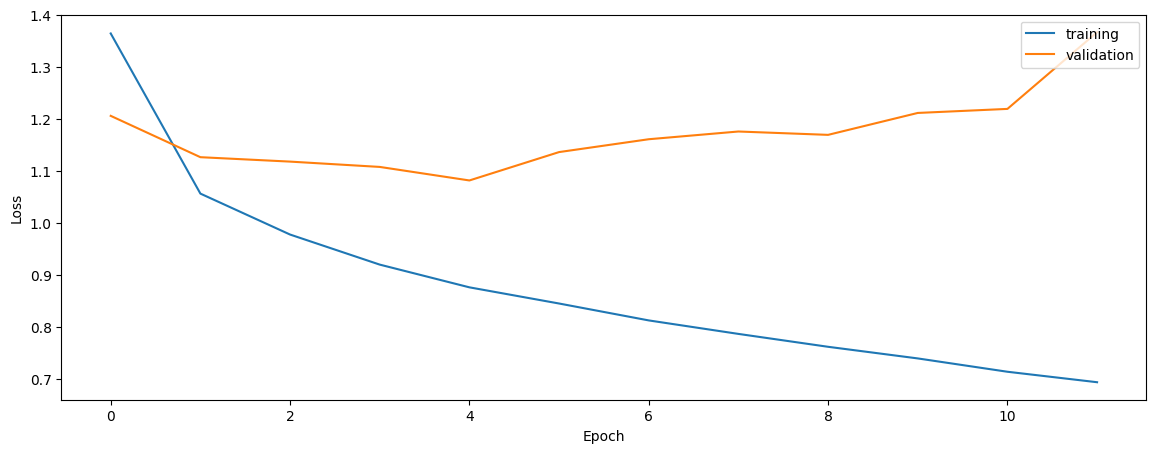

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6764946824396071
0.5686195672248214
0.6467654976274486


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized


0.5493637614920331
0.5308123798491362
0.5018418511900654


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.5466430515251737
0.5448056807647876
0.506886090043388


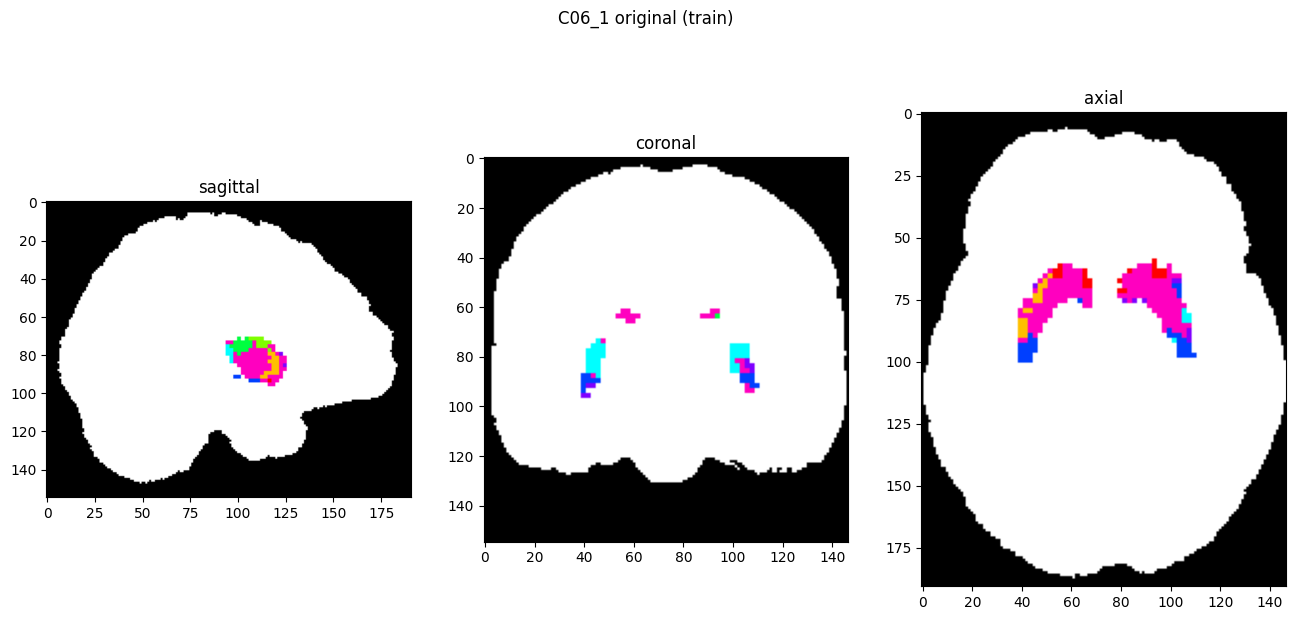

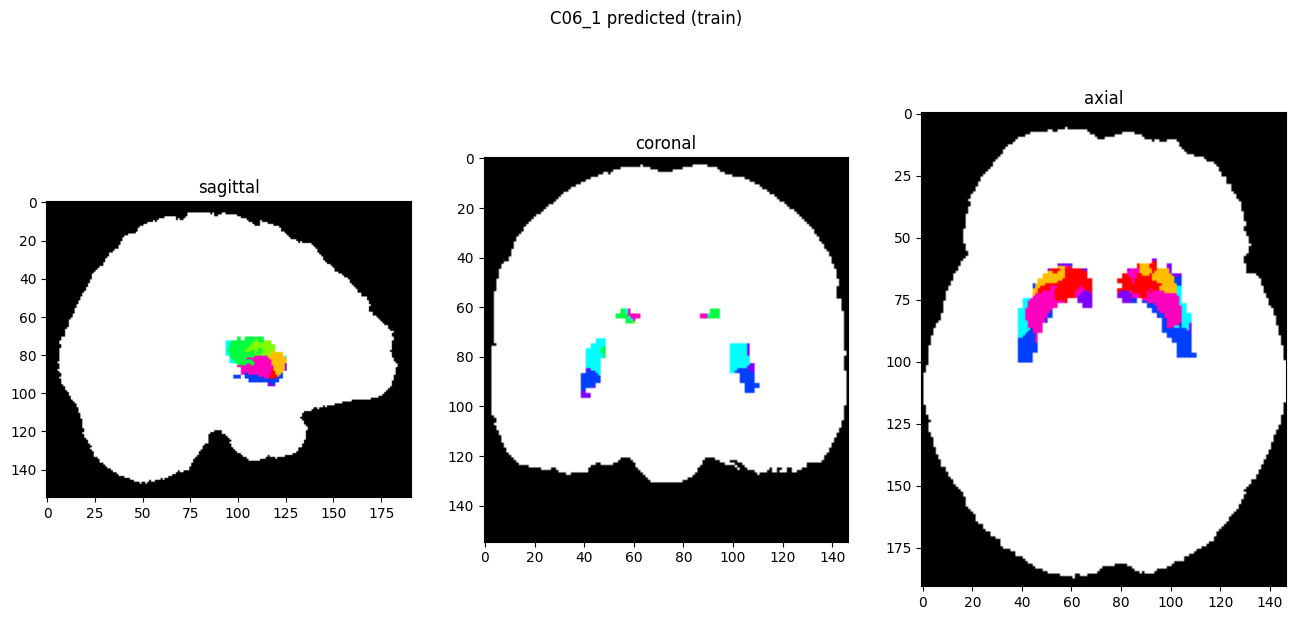

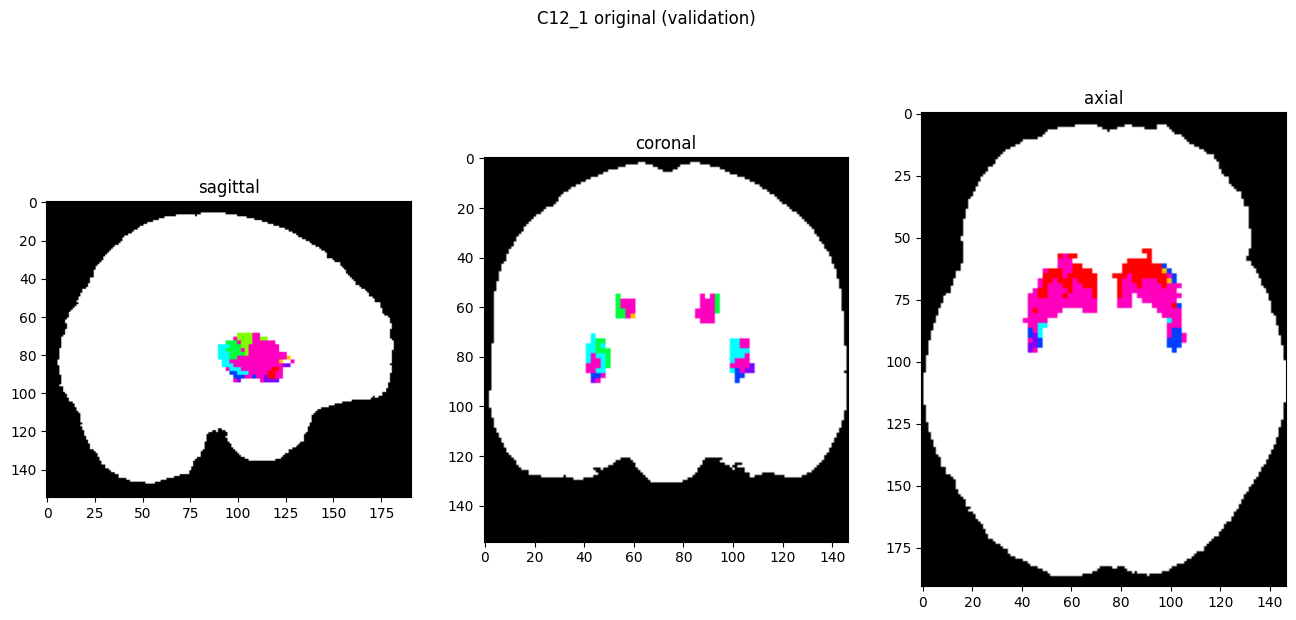

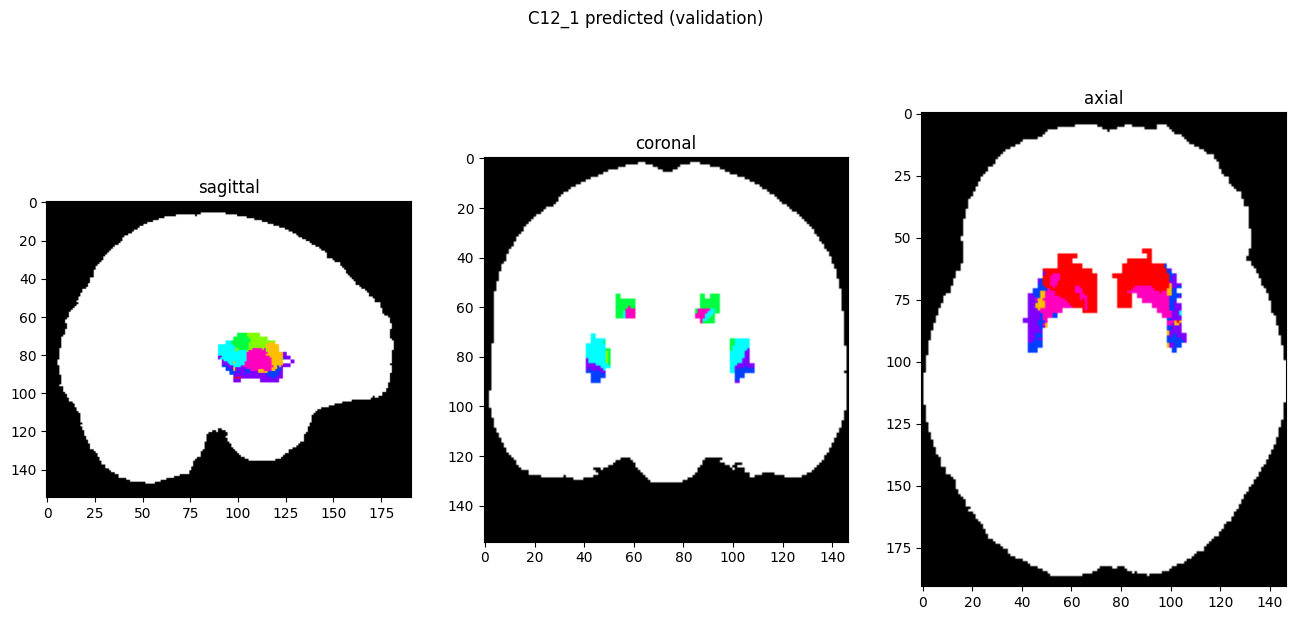

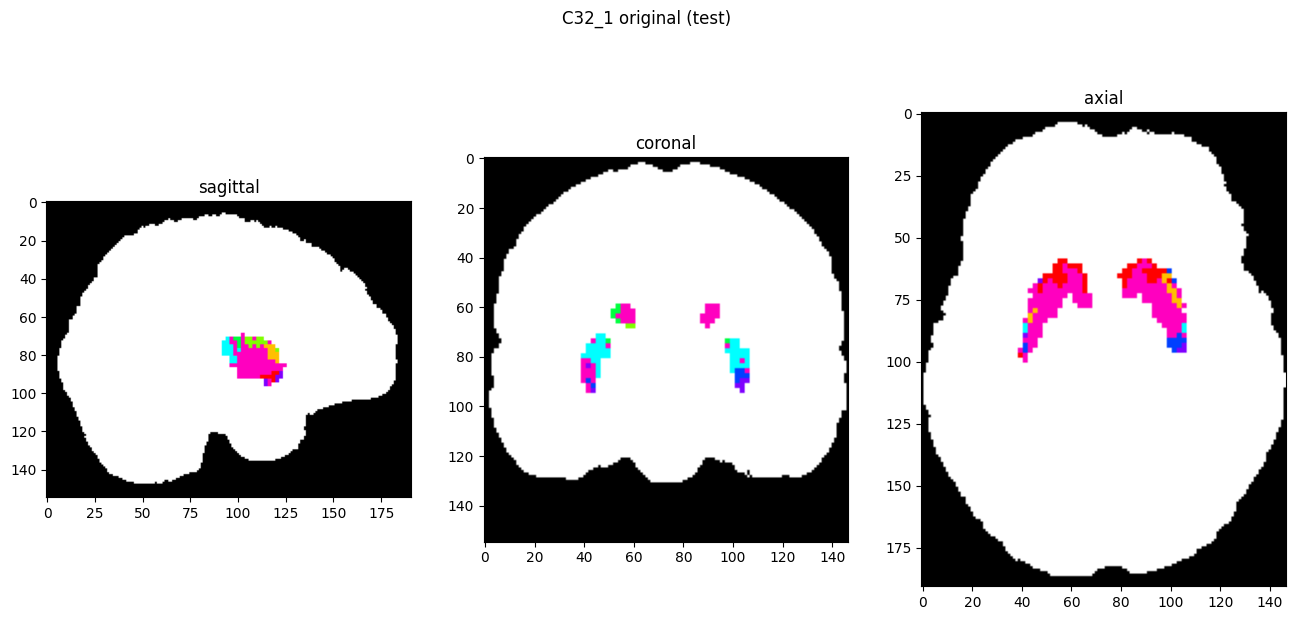

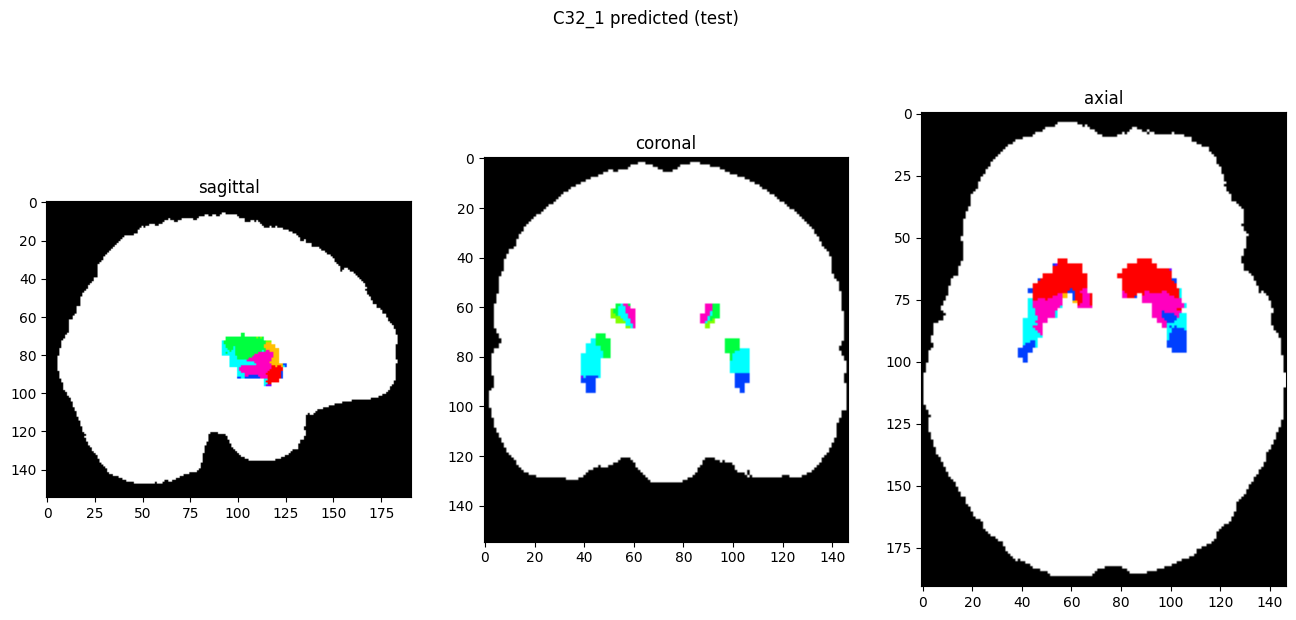

In [10]:
showResults(model, gen, threshold=0)